In [2]:
import math
import pickle
import time
from functools import reduce
from pandarallel import pandarallel

import dask.dataframe as ddf
import jqdatasdk as jq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
import plotly.graph_objects as go
from csmarapi.CsmarService import CsmarService
from plotly.subplots import make_subplots
from scipy import stats
from utils.my_cache import cache_wrapper
from utils.functions import *

from csmarapi.ReportUtil import ReportUtil


In [3]:
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False
csmar = CsmarService()
pandarallel.initialize()

csmar.login('wuhh@pbcsf.tsinghua.edu.cn', 'whh8803582')

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


Tue 25 Oct 2022 08:54:59 CsmarService.py INFO User login succeed


## **I. Data**

**Research**

- Most Data (nav/dividend/split ratio/asset allocation) : `CSMAR`

- Fund classification : `JoinQuant`

- Fund start date: `JoinQuant`

- SVC related: `previous research`

**Validation**

- `AMAC` : [2020 yearly report, page 15](https://www.amac.org.cn/researchstatistics/publication/zgzqtzjjynb/202104/t20210419_11390.html), for market statistic

- `Win.d` : classification/share/nav, for market statistic; stock fund adjusted net asset value (2005/6-2019/6)

<span style="color:blue">Data is sound, carefully verified and available to fetch</span>

AMAC

In [8]:
from data.AMAC.amac_full_market_value import amac_full_market_value

JoinQuant

In [9]:
from data.JoinQuant.jq_all_fund_brief import *
from data.JoinQuant.jq_all_fund_main_info import jq_all_fund_main_info
from data.JoinQuant.jq_all_stocks_brief import jq_all_stocks_brief
from data.JoinQuant.jq_stock_classification import jq_stock_classification

Win.d

In [18]:
from data.Wind.wind_validate_share_nav import *
from data.Wind.wind_validate_stock_fund_adj_nav import wind_validate_stock_fund_adj_nav
from data.Wind.wind_stock_classification import *

CSMAR

In [11]:
from data.CSMAR.TRD_Co import csmar_stock_classification
from data.CSMAR.FUND_MainInfo import csmar_maininfo
from data.CSMAR.FUND_FundCodeInfo import csmar_symbol_code_mapping
from data.CSMAR.Fund_ShareChange import csmar_share_info
from data.CSMAR.daily_nav import csmar_nav_daily
from data.CSMAR.Fund_FundDividend import csmar_fund_dividend
from data.CSMAR.Fund_Resolution import csmar_fund_resolution
from data.CSMAR.Fund_Allocation import csmar_fund_allocation
from data.CSMAR.invest_detail import csmar_invest_detail
from data.CSMAR.TRD_Mnth import csmar_monthly_stock

SVC

In [16]:
from data.SVC.svc_source import svc_source

TwoStep

In [17]:
from data.TwoStepData.csmar_nav_monthly import csmar_nav_monthly

## **II. Market Statistic**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data.CSMAR.Fund_ShareChange import csmar_share_info
from data.JoinQuant.jq_all_fund_main_info import jq_all_fund_main_info
from data.TwoStepData.csmar_nav_monthly import csmar_nav_monthly
from data.Wind.wind_validate_share_nav import *
from utils.functions import *

auth success 


split Win.d data

|       | share            | nav            |
| ----- | ---------------- | -------------- |
| all | all fund share | all fund nav |
| blend | blend fund share | blend fund nav |

In [ ]:
wind_validate_share = wind_validate_share_nav.loc['基金份额', slice(None)]
wind_validate_share.columns = wind_validate_share.columns.str.split('.').str[0]
wind_validate_share = wind_validate_share[ ~ wind_validate_share.index.duplicated(keep='last')]

In [20]:
wind_validate_nav = wind_validate_share_nav.loc['单位净值', slice(None)]
wind_validate_nav.columns = wind_validate_nav.columns.str.split('.').str[0]
wind_validate_nav = wind_validate_nav[ ~ wind_validate_nav.index.duplicated(keep='last')]

In [ ]:
wind_stock_fund_share = wind_validate_share.T[(wind_fund_classification['投资类型(一级分类)'] == '股票型基金').values].T
wind_blend_fund_share = wind_validate_share.T[(wind_fund_classification['投资类型(一级分类)'] == '混合型基金').values].T

wind_stock_fund_nav = wind_validate_nav.T[(wind_fund_classification['投资类型(一级分类)'] == '股票型基金').values].T
wind_blend_fund_nav = wind_validate_nav.T[(wind_fund_classification['投资类型(一级分类)'] == '混合型基金').values].T

make Win.d data plottable

In [22]:
wind_stock_fund_num = pd.notna(wind_stock_fund_nav).sum(axis=1)
wind_stock_fund_num.index = wind_stock_fund_num.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_blend_fund_num = pd.notna(wind_blend_fund_nav).sum(axis=1)
wind_blend_fund_num.index = wind_blend_fund_num.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_stock_fund_mkt_value = (wind_stock_fund_share * wind_stock_fund_nav).sum(axis=1)
wind_stock_fund_mkt_value.index  = wind_stock_fund_mkt_value.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_blend_fund_mkt_value = (wind_blend_fund_share * wind_blend_fund_nav).sum(axis=1)
wind_blend_fund_mkt_value.index  = wind_blend_fund_mkt_value.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

align JoinQuant && CSMAR data

In [23]:
csmar_share_info = csmar_share_info.drop_duplicates(subset=['Symbol', 'Date']).pivot(index='Date', columns='Symbol', values='EndDateShares')


In [24]:
selected_month = 6

csmar_share_info_6 = csmar_share_info[csmar_share_info.index.month == selected_month]
csmar_nav_monthly_6 = csmar_nav_monthly[csmar_nav_monthly.index.month == selected_month]

csmar_blend_code_6 = np.intersect1d(csmar_nav_monthly_6.columns, jq_all_fund_main_info[jq_all_fund_main_info.underlying_asset_type == '混合型'].main_code.values)
csmar_blend_code_6 = np.intersect1d(csmar_blend_code_6, csmar_share_info_6.columns)

csmar_stock_code_6 = np.intersect1d(csmar_nav_monthly_6.columns, jq_all_fund_main_info[jq_all_fund_main_info.underlying_asset_type == '股票型'].main_code.values)
csmar_stock_code_6 = np.intersect1d(csmar_stock_code_6, csmar_share_info_6.columns)

csmar_co_time_6 = np.intersect1d(csmar_share_info_6.index, csmar_nav_monthly_6.index)




In [25]:
csmar_blend_mkt_value_jq_classify = (csmar_share_info_6.loc[csmar_co_time_6, csmar_blend_code_6] * csmar_nav_monthly_6.loc[csmar_co_time_6, csmar_blend_code_6]).sum(axis=1)
csmar_stock_mkt_value_jq_classify = (csmar_share_info_6.loc[csmar_co_time_6, csmar_stock_code_6] * csmar_nav_monthly_6.loc[csmar_co_time_6, csmar_stock_code_6]).sum(axis=1)

csmar_stock_mkt_value_jq_classify.index = csmar_stock_mkt_value_jq_classify.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)
csmar_blend_mkt_value_jq_classify.index = csmar_blend_mkt_value_jq_classify.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

stock funds market value

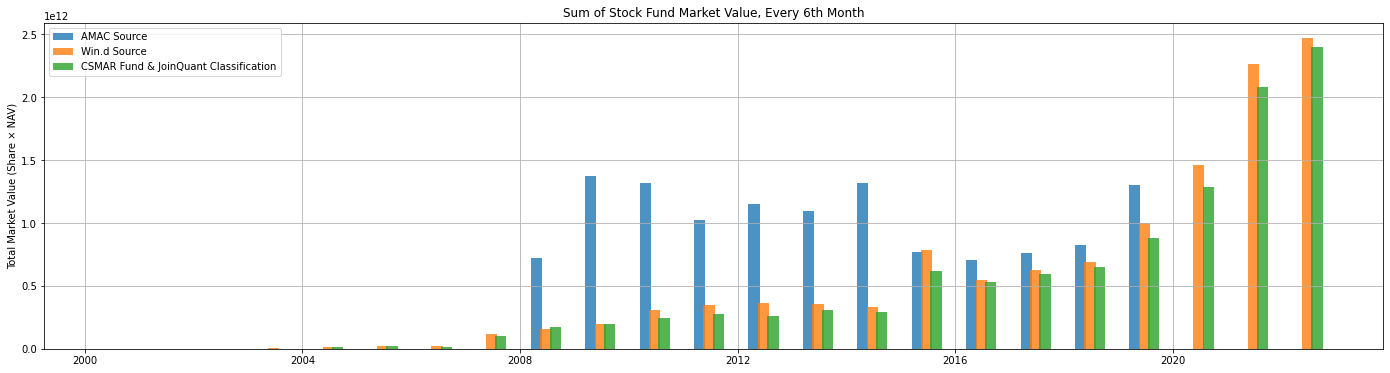

In [26]:
plt.figure(figsize=(24, 6))
plt.bar(amac_full_market_value.股票基金.index - pd.Timedelta('10W'), amac_full_market_value.股票基金.values * 1e8, width=75, label='AMAC Source', alpha=.8)
plt.bar(wind_stock_fund_mkt_value.index - pd.Timedelta('1W'), wind_stock_fund_mkt_value.values, width=75, label='Win.d Source', alpha=.8)
plt.bar(csmar_stock_mkt_value_jq_classify.index + pd.Timedelta('8W'), csmar_stock_mkt_value_jq_classify.values, width=75, label='CSMAR Fund & JoinQuant Classification', alpha=.8)
plt.grid()
plt.ylabel('Total Market Value (Share × NAV)')
plt.title('Sum of Stock Fund Market Value, Every 6th Month')
plt.legend()

blend funds market value

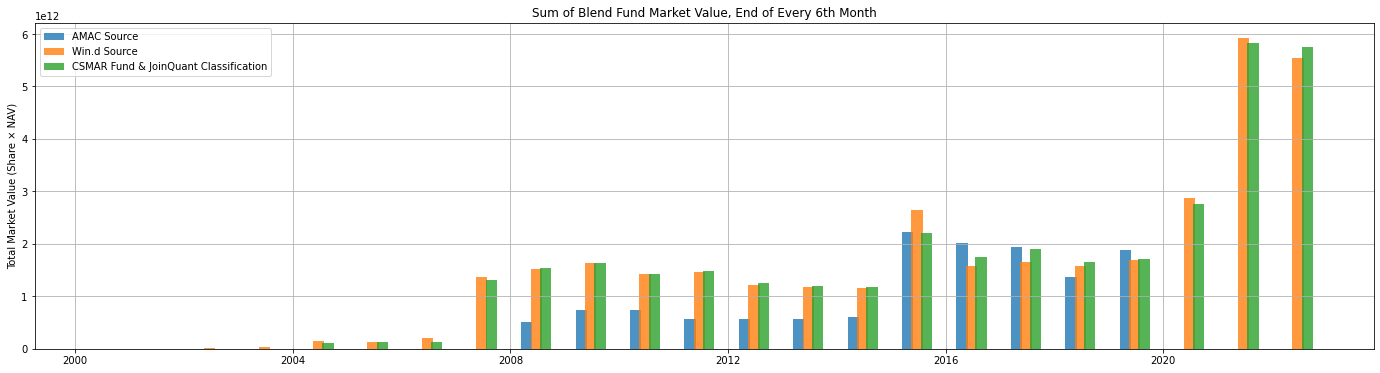

In [27]:
plt.figure(figsize=(24, 6))
plt.bar(amac_full_market_value.混合基金.index - pd.Timedelta('10W'), amac_full_market_value.混合基金.values * 1e8, width=75, label='AMAC Source', alpha=.8)
plt.bar(wind_blend_fund_mkt_value.index - pd.Timedelta('1W'), wind_blend_fund_mkt_value.values, width=75, label='Win.d Source', alpha=.8)
plt.bar(csmar_blend_mkt_value_jq_classify.index + pd.Timedelta('8W'), csmar_blend_mkt_value_jq_classify.values, width=75, label='CSMAR Fund & JoinQuant Classification', alpha=.8)
plt.grid()
plt.ylabel('Total Market Value (Share × NAV)')
plt.title('Sum of Blend Fund Market Value, End of Every 6th Month')
plt.legend()

(stock + blend) funds market value

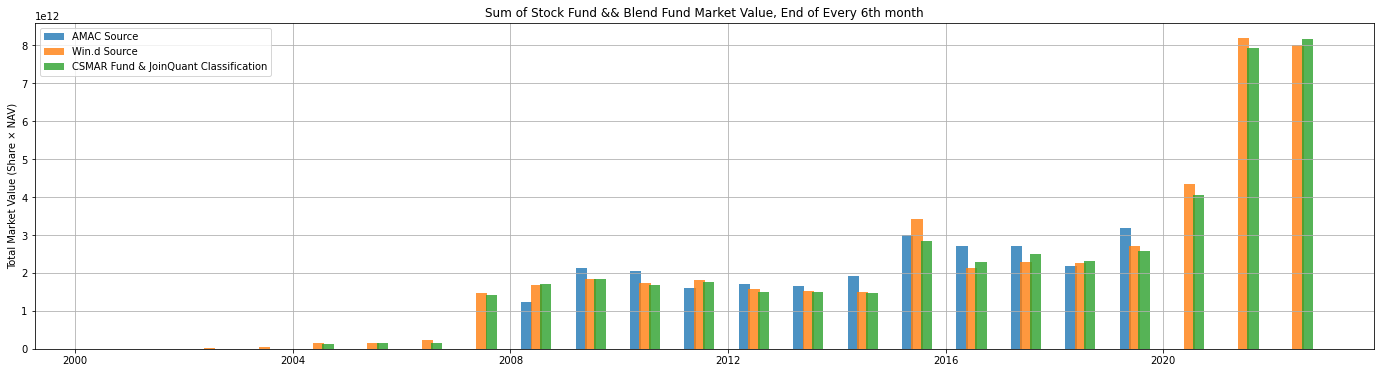

In [28]:
plt.figure(figsize=(24, 6))
plt.bar(amac_full_market_value.混合基金.index - pd.Timedelta('10W'), (amac_full_market_value.混合基金.values + amac_full_market_value.股票基金.values) * 1e8, width=75, label='AMAC Source', alpha=.8)
plt.bar(wind_blend_fund_mkt_value.index - pd.Timedelta('1W'), \
     wind_blend_fund_mkt_value.values + wind_stock_fund_mkt_value.values, width=75, label='Win.d Source', alpha=.8)
plt.bar(csmar_blend_mkt_value_jq_classify.index + pd.Timedelta('8W'), \
     csmar_blend_mkt_value_jq_classify.values + csmar_stock_mkt_value_jq_classify.values, width=75, label='CSMAR Fund & JoinQuant Classification', alpha=.8)
plt.grid()
plt.ylabel('Total Market Value (Share × NAV)')
plt.title('Sum of Stock Fund && Blend Fund Market Value, End of Every 6th month')
plt.legend()

fund counts

In [29]:
csmar_stock_fund_count = csmar_nav_monthly.loc[:, csmar_stock_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_stock_fund_count.index = csmar_stock_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

csmar_blend_fund_count = csmar_nav_monthly.loc[:, csmar_blend_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_blend_fund_count.index = csmar_blend_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

integrated plot

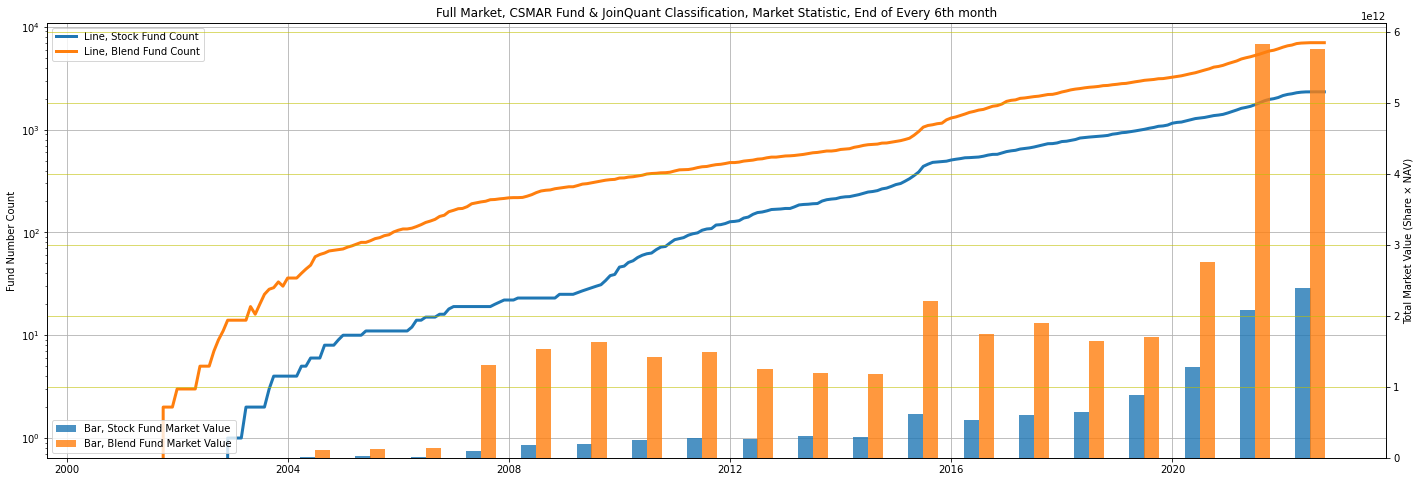

In [30]:
fig, ax1 = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(24)

csmar_nav_monthly_6.loc[:, csmar_blend_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)

csmar_stock_fund_count = csmar_nav_monthly.loc[:, csmar_stock_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_stock_fund_count.index = csmar_stock_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

csmar_blend_fund_count = csmar_nav_monthly.loc[:, csmar_blend_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_blend_fund_count.index = csmar_blend_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)


ax1.plot(csmar_stock_fund_count, linewidth=3, label='Line, Stock Fund Count')
ax1.plot(csmar_blend_fund_count, linewidth=3, label='Line, Blend Fund Count')

ax1.set_yscale('log')
ax1.set_yticks([1e0, 1e1, 1e2, 1e3, 1e4])
ax1.grid()
ax1.set_ylabel('Fund Number Count')

ax2 = ax1.twinx()

plt.bar(csmar_stock_mkt_value_jq_classify.index - pd.Timedelta('7W'), \
     csmar_stock_mkt_value_jq_classify.values, width=100, label='Bar, Stock Fund Market Value', alpha=.8)

plt.bar(csmar_blend_mkt_value_jq_classify.index + pd.Timedelta('7W'), \
     csmar_blend_mkt_value_jq_classify.values, width=100, label='Bar, Blend Fund Market Value', alpha=.8)

plt.title('Full Market, CSMAR Fund & JoinQuant Classification, Market Statistic, End of Every 6th month')

ax2.grid(color='y', alpha=.7)
plt.ylabel('Total Market Value (Share × NAV)')

ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
plt.show()


## **III. Filters**

In [ ]:
from functools import reduce

import numpy as np
import pandas as pd

from data.CSMAR.daily_nav import csmar_nav_daily
from data.CSMAR.Fund_Allocation import csmar_fund_allocation
from data.CSMAR.FUND_FundCodeInfo import csmar_symbol_code_mapping
from data.CSMAR.Fund_FundDividend import csmar_fund_dividend
from data.CSMAR.FUND_MainInfo import csmar_maininfo
from data.CSMAR.Fund_Resolution import csmar_fund_resolution
from data.JoinQuant.jq_all_fund_main_info import jq_all_fund_main_info
from data.TwoStepData.csmar_nav_monthly import csmar_nav_monthly

### preview

In [39]:
csmar_jq_co_fund = np.intersect1d(np.char.zfill(csmar_nav_daily.Symbol.unique().astype(str), 6), jq_all_fund_main_info.main_code)
csmar_jq_co_fund = pd.Series(csmar_jq_co_fund, name='main_code')

final_main_info = pd.merge(jq_all_fund_main_info, csmar_jq_co_fund, on='main_code')[['main_code', 'operate_mode', 'underlying_asset_type', 'start_date']]


In [40]:
specs = [[{'type':'domain'}] * 2]
fig = make_subplots(rows=1, cols=2, specs=specs, subplot_titles=['JoinQuant Asset Type', 'JoinQuant Operation Mode'])
fig.add_trace(go.Pie(labels=final_main_info.underlying_asset_type.value_counts().index, values=final_main_info.underlying_asset_type.value_counts().values), 1, 1)
fig.add_trace(go.Pie(labels=final_main_info.operate_mode.value_counts().index, values=final_main_info.operate_mode.value_counts().values), 1, 2)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update(layout_showlegend=False)
fig.update_layout(width=1200, height=500)

### 1. static filtering

（1）基金类别为“股票型基金”或“混合型基金”；


（2）基金非 ETF 类基金、非 QDII 类基金

<!-- （4）主动管理标识为 1 或者为空； -->

In [41]:
final_main_info

,main_code,operate_mode,underlying_asset_type,start_date
0,000001,开放式基金,混合型,2001-12
1,000003,开放式基金,债券型,2013-03
2,000004,开放式基金,债券型,2013-03
3,000005,开放式基金,债券型,2013-03
4,000006,开放式基金,混合型,2019-03
...,...,...,...,...
16387,968083,开放式基金,债券型,2020-04
16388,968084,开放式基金,债券型,2020-04
16389,968085,开放式基金,债券型,2020-04
16390,968086,开放式基金,债券型,2020-04


In [42]:
filter_1 = np.logical_or(final_main_info.underlying_asset_type == '股票型', final_main_info.underlying_asset_type == '混合型')
filter_2 = np.logical_and(final_main_info.operate_mode != 'ETF', final_main_info.operate_mode != 'QDII')

filters = [(1, filter_1), (2, filter_2)]
np.array(list(map(lambda _: _[1].sum(), filters))) / len(final_main_info)

# proportional data left

array([0.62005857, 0.93191801])

In [43]:

def func(previous, now):
    if type(previous) == tuple:
        print(f'filter {previous[0]}: {len(final_main_info)} to {previous[1].sum()}')
        temp = np.logical_and(previous[1], now[1])
        print(f'filter {now[0]}: {previous[1].sum()} to {temp.sum()}')
        return temp
    else:
        temp = np.logical_and(previous, now[1])
        print(f'filter {now[0]}: {previous.sum()} to {temp.sum()}')
        return temp


filters_ = reduce(func, filters)

filter 1: 16392 to 10164
filter 2: 10164 to 9253


In [44]:
final_main_info = final_main_info[filters_]
final_main_info.set_index('main_code').sort_index()

,operate_mode,underlying_asset_type,start_date
main_code,,,
000001,开放式基金,混合型,2001-12
000006,开放式基金,混合型,2019-03
000011,开放式基金,混合型,2004-08
000017,开放式基金,混合型,2013-03
000020,开放式基金,混合型,2013-03
...,...,...,...
968045,开放式基金,股票型,2019-03
968046,开放式基金,股票型,2019-03
968047,开放式基金,股票型,2019-03


### 2. big table

from `code` indexed only to `code-month` multiIndex

In [45]:
indexes = pd.MultiIndex.from_product([final_main_info.main_code.sort_values().values, pd.date_range('2000-1', '2022-10', freq='M')])
temp_codes = indexes.get_level_values(0)
temp_date = indexes.get_level_values(1)
main_data = pd.DataFrame(index=indexes)
main_data['main_code'] = temp_codes
main_data['Date'] = temp_date.to_period('M')
main_data = pd.merge(main_data, final_main_info, on='main_code')
main_data = main_data.rename(columns={'main_code': 'Symbol'})
main_data = main_data.set_index(['Symbol', 'Date'])
main_data = main_data.loc[csmar_nav_monthly[final_main_info.main_code.sort_values().values].stack().index.swaplevel()].sort_index()
main_data

operate_mode underlying_asset_type start_date
Symbol Date                                                 
000001 2001-12        开放式基金                   混合型    2001-12
       2002-01        开放式基金                   混合型    2001-12
       2002-02        开放式基金                   混合型    2001-12
       2002-03        开放式基金                   混合型    2001-12
       2002-04        开放式基金                   混合型    2001-12
...                     ...                   ...        ...
968049 2022-05        开放式基金                   股票型    2019-03
       2022-06        开放式基金                   股票型    2019-03
       2022-07        开放式基金                   股票型    2019-03
       2022-08        开放式基金                   股票型    2019-03
       2022-09        开放式基金                   股票型    2019-03

[418488 rows x 3 columns]

### 3. dynamic filtering

（3）基金上市时间超过一年

（4）最近一次**二季度报/年报/半年报**~~年报或半年报~~披露的中国市场股票持股比例超过总管理规模的30%

In [46]:
main_data = main_data[main_data.index.get_level_values(1) >= main_data.start_date + pd.offsets.MonthEnd(12)]
record_shape = len(main_data.index.get_level_values(0).unique())
f'in view of 2022, filter 3: {len(final_main_info)} to {record_shape}'

'in view of 2022, filter 3: 9253 to 7157'

*problem*: annual report or semi-annual report not available before 2008

*reason*: regulation rule changed

*solve*: add second quarter report

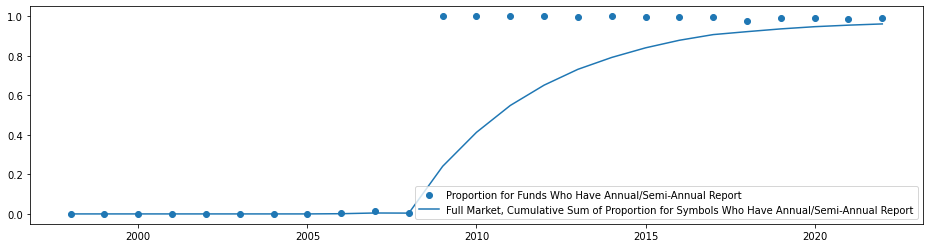

In [47]:
csmar_fund_allocation['report_type_check'] = csmar_fund_allocation.Date.dt.year
report_type_check = csmar_fund_allocation.groupby(['MasterFundCode', 'report_type_check']).apply(lambda temp : 5 in temp.ReportTypeID.values or 6 in temp.ReportTypeID.values)
plt.figure(figsize=(16,4))
report_type_check_ = report_type_check.groupby(level=1).apply(lambda temp: temp.sum() / len(temp))
year_report_count = report_type_check.groupby(level=1).apply(lambda temp: temp.sum())
total_report_count = report_type_check.groupby(level=1).apply(lambda temp: len(temp))
plt.scatter(x=report_type_check_.index, y=report_type_check_.values, label='Proportion for Funds Who Have Annual/Semi-Annual Report')
temp = year_report_count.cumsum() / total_report_count.cumsum()
plt.plot(temp.index, temp.values, label='Full Market, Cumulative Sum of Proportion for Symbols Who Have Annual/Semi-Annual Report')
plt.legend()
pass

<img src="image/README/2008_search.png" alt="drawing" width="500"/> <img src="image/README/2009_search.png" alt="drawing" width="508"/>

[中国证券监督管理委员会公告〔2008〕第4号](http://www.gov.cn/zwgk/2008-02/21/content_896020.htm)


使用存在二季度报/年报/半年报的数据

In [48]:
csmar_fund_allocation = csmar_fund_allocation[csmar_fund_allocation.ReportTypeID.isin([2, 5, 6])]
csmar_fund_allocation = pd.merge(csmar_fund_allocation, csmar_symbol_code_mapping, on='MasterFundCode', how='left')
csmar_fund_allocation = csmar_fund_allocation[csmar_fund_allocation.Symbol.isin(main_data.index.get_level_values(0).unique())]
main_data = main_data.loc[csmar_fund_allocation.Symbol.unique(), slice(None)]

中国市场股票持股比例超过总管理规模30%

In [49]:
filter_4 = csmar_fund_allocation[(csmar_fund_allocation.Equity / csmar_fund_allocation.TotalAsset) > .3]
co_index = np.intersect1d(filter_4.set_index(['Symbol', 'Date']).index, main_data.index)
main_data['filter_4'] = np.nan
main_data.loc[main_data.index.get_level_values(1).month == 6, 'filter_4'] = False
main_data.loc[co_index, 'filter_4'] = True
main_data = main_data.groupby(level=0).fillna(method='ffill').fillna(False)
main_data = main_data[main_data.filter_4].drop('filter_4', axis=1)
main_data

operate_mode underlying_asset_type start_date
Symbol Date                                                 
000001 2003-06        开放式基金                   混合型    2001-12
       2003-07        开放式基金                   混合型    2001-12
       2003-08        开放式基金                   混合型    2001-12
       2003-09        开放式基金                   混合型    2001-12
       2003-10        开放式基金                   混合型    2001-12
...                     ...                   ...        ...
952009 2022-05        封闭式基金                   混合型    2020-01
       2022-06        封闭式基金                   混合型    2020-01
       2022-07        封闭式基金                   混合型    2020-01
       2022-08        封闭式基金                   混合型    2020-01
       2022-09        封闭式基金                   混合型    2020-01

[235912 rows x 3 columns]

In [50]:
f'in view of all time span, filter 4: {record_shape} to {len(main_data.index.get_level_values(0).unique())}'

'in view of all time span, filter 4: 7157 to 5291'

### 4. full data

reset nav

In [52]:
csmar_nav_monthly = pd.Series(csmar_nav_monthly.stack().swaplevel(), name='NAV')
csmar_nav_monthly = pd.DataFrame(csmar_nav_monthly).reset_index()

merge data

In [53]:
main_data = pd.merge(main_data, csmar_nav_monthly, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])
main_data = pd.merge(main_data, csmar_fund_dividend, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])
main_data = pd.merge(main_data, csmar_fund_resolution, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])

handle NA

In [54]:
main_data['NAV'] = main_data.groupby(level=0).apply(lambda x: x.NAV.fillna(method='ffill')).droplevel(0)
main_data['DividendperShare'] = main_data.DividendperShare.fillna(0)
main_data['SplitRatio'] = main_data.SplitRatio.fillna(1)

combine csmar category

In [55]:
csmar_category_symbol_mapping = pd.merge(csmar_maininfo[['MasterFundCode', 'Category']].drop_duplicates(), \
    csmar_symbol_code_mapping, on='MasterFundCode', how='left')[['Category', 'Symbol']]
csmar_category_symbol_mapping = csmar_category_symbol_mapping.drop_duplicates().reset_index(drop=True)
csmar_category_symbol_mapping = csmar_category_symbol_mapping.groupby('Symbol').last()

main_data = pd.merge(main_data.reset_index(), csmar_category_symbol_mapping, on='Symbol').set_index(['Symbol', 'Date'])
main_data

operate_mode underlying_asset_type  ... SplitRatio Category_y
Symbol Date                                        ...                      
000001 2003-06        开放式基金                   混合型  ...        1.0      混合型基金
       2003-07        开放式基金                   混合型  ...        1.0      混合型基金
       2003-08        开放式基金                   混合型  ...        1.0      混合型基金
       2003-09        开放式基金                   混合型  ...        1.0      混合型基金
       2003-10        开放式基金                   混合型  ...        1.0      混合型基金
...                     ...                   ...  ...        ...        ...
952009 2022-05        封闭式基金                   混合型  ...        1.0      混合型基金
       2022-06        封闭式基金                   混合型  ...        1.0      混合型基金
       2022-07        封闭式基金                   混合型  ...        1.0      混合型基金
       2022-08        封闭式基金                   混合型  ...        1.0      混合型基金
       2022-09        封闭式基金                   混合型  ...        1.0      混合型基金

[235808 rows x 8 columns]

## **IV. Overall Performance**

### Return

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*SF_t}{NAV_{t-1}*SF_{t-1}}\tag{1}
$$

$NAV_t$ 基金在 $t$ 月末的基金净值

$Div_t$ 在 $t$ 月中发放的现金分红

$SF_t$ 累计拆分因子

当$t$月中发生比例为$s_t$的拆分时, $SF_t=s_tSF_{t-1}$

公式等价于

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*s_t}{NAV_{t-1}}\tag{2}
$$

#### 1. prepare

In [16]:
from functools import reduce

import numpy as np
import pandas as pd

from data.CSMAR.daily_nav import csmar_nav_daily
from data.CSMAR.Fund_Allocation import csmar_fund_allocation
from data.CSMAR.FUND_FundCodeInfo import csmar_symbol_code_mapping
from data.CSMAR.Fund_FundDividend import csmar_fund_dividend
from data.CSMAR.FUND_MainInfo import csmar_maininfo
from data.CSMAR.Fund_Resolution import csmar_fund_resolution
from data.JoinQuant.jq_all_fund_main_info import jq_all_fund_main_info
from data.TwoStepData.csmar_nav_monthly import csmar_nav_monthly

auth success 


NAV_shift calculation

In [17]:
main_data['NAV_shift'] = main_data.groupby(level=0).apply(lambda x: x.NAV.shift(1)).droplevel(0)

NameError: name 'main_data' is not defined

split into stock fund and blend fund

apply formula

In [ ]:
blend_data = main_data[main_data.underlying_asset_type == '混合型']
stock_data = main_data[main_data.underlying_asset_type == '股票型']


return_of_csmar_stock_fund = stock_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)
return_of_csmar_blend_fund = blend_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)
return_of_all_fund = main_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)


market value weight generation

In [ ]:
MONTH_OF_YEAR = 6

csmar_share_info = csmar_share_info.drop_duplicates(subset=['Symbol', 'Date']).pivot(index='Date', columns='Symbol', values='EndDateShares')

csmar_share_info_yearly = csmar_share_info[csmar_share_info.index.month == MONTH_OF_YEAR]
csmar_nav_yearly = csmar_nav_monthly[csmar_nav_monthly.index.month == MONTH_OF_YEAR]

csmar_co_time_6 = np.intersect1d(csmar_share_info_yearly.index, csmar_nav_yearly.index)

csmar_blend_code_6 = np.intersect1d(csmar_nav_yearly.columns, jq_all_fund_main_info[jq_all_fund_main_info.underlying_asset_type == '混合型'].main_code.values)
csmar_blend_code_6 = np.intersect1d(csmar_blend_code_6, csmar_share_info_yearly.columns)

csmar_stock_code_6 = np.intersect1d(csmar_nav_yearly.columns, jq_all_fund_main_info[jq_all_fund_main_info.underlying_asset_type == '股票型'].main_code.values)
csmar_stock_code_6 = np.intersect1d(csmar_stock_code_6, csmar_share_info_yearly.columns)



csmar_stock_fund_weight_yearly = (csmar_share_info_yearly.loc[csmar_co_time_6, csmar_stock_code_6] * csmar_nav_yearly.loc[csmar_co_time_6, csmar_stock_code_6])

csmar_stock_fund_weight_yearly = pd.concat([csmar_stock_fund_weight_yearly, \
    pd.DataFrame([[np.nan] * csmar_stock_fund_weight_yearly.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=csmar_stock_fund_weight_yearly.columns)])

csmar_stock_fund_weight_yearly = csmar_stock_fund_weight_yearly.resample('M').ffill()

stock_fund_dates = return_of_csmar_stock_fund.unstack(level=0).index
stock_fund_funds = return_of_csmar_stock_fund.unstack(level=0).columns

stock_fund_new = np.setdiff1d(stock_fund_funds, csmar_stock_fund_weight_yearly.columns)
print(f'{stock_fund_new} will not be used')

stock_fund_funds = np.intersect1d(stock_fund_funds, csmar_stock_fund_weight_yearly.columns)

csmar_stock_fund_weight_yearly = csmar_stock_fund_weight_yearly.loc[stock_fund_dates, stock_fund_funds]
csmar_stock_fund_weight_yearly = csmar_stock_fund_weight_yearly.div(csmar_stock_fund_weight_yearly.sum(axis=1), axis=0)

[] will not be used


In [ ]:

csmar_blend_fund_weight_yearly = (csmar_share_info_yearly.loc[csmar_co_time_6, csmar_blend_code_6] * csmar_nav_yearly.loc[csmar_co_time_6, csmar_blend_code_6])
csmar_blend_fund_weight_yearly = pd.concat([csmar_blend_fund_weight_yearly, \
    pd.DataFrame([[np.nan] * csmar_blend_fund_weight_yearly.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=csmar_blend_fund_weight_yearly.columns)])
csmar_blend_fund_weight_yearly = csmar_blend_fund_weight_yearly.resample('M').ffill()

blend_fund_dates = return_of_csmar_blend_fund.unstack(level=0).index
blend_fund_funds = return_of_csmar_blend_fund.unstack(level=0).columns

blend_fund_new = np.setdiff1d(blend_fund_funds, csmar_blend_fund_weight_yearly.columns)
print(f'{blend_fund_new} will not be used')
blend_fund_funds = np.intersect1d(blend_fund_funds, csmar_blend_fund_weight_yearly.columns)

csmar_blend_fund_weight_yearly = csmar_blend_fund_weight_yearly.loc[blend_fund_dates, blend_fund_funds]
csmar_blend_fund_weight_yearly = csmar_blend_fund_weight_yearly.div(csmar_blend_fund_weight_yearly.sum(axis=1), axis=0)


['960002' '960004'] will not be used


#### 2. analysis

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from IPython.display import display

from data.SVC.svc_source import svc_source
from data.TwoStepData.csmar_blend_fund_weight_yearly import csmar_blend_fund_weight_yearly
from data.TwoStepData.csmar_stock_fund_weight_yearly import csmar_stock_fund_weight_yearly
from data.TwoStepData.return_of_csmar_blend_fund import return_of_csmar_blend_fund
from data.TwoStepData.return_of_csmar_stock_fund import return_of_csmar_stock_fund
from data.TwoStepData.regression_source import regression_source
from utils.functions import *


use data later than 2005-06

In [83]:
return_of_csmar_stock_fund.unstack(level=0) - 1

Symbol,000042,000059,000082,000176,000309,000311,000312,000313,000326,000368,...,660011,671030,673090,673100,673101,690008,700002,740101,960000,960022
Date,,,,,,,,,,,,,,,,,,,,,
2004-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05,0.020766,0.047896,0.052759,0.019350,0.151059,0.006233,0.030889,0.030550,0.111645,0.029243,...,0.069429,0.085950,0.026093,0.015870,0.015432,0.062696,0.037784,0.031538,0.027870,NaN
2022-06,0.083720,0.093872,0.097926,0.108846,0.162114,0.099558,0.119288,0.118925,0.121493,0.075491,...,0.073979,0.186415,0.074244,0.107217,0.106920,0.073746,0.108399,0.108128,0.077097,NaN
2022-07,-0.051055,-0.072915,-0.042497,-0.065595,0.009198,-0.061569,-0.060569,-0.060905,-0.035050,-0.056234,...,-0.020499,-0.048581,-0.049545,-0.059227,-0.059529,-0.032967,-0.053751,-0.053163,-0.065693,NaN


Text(0.5, 1.0, 'Across Funds, Mean of Rolling 12 Months Volatility')

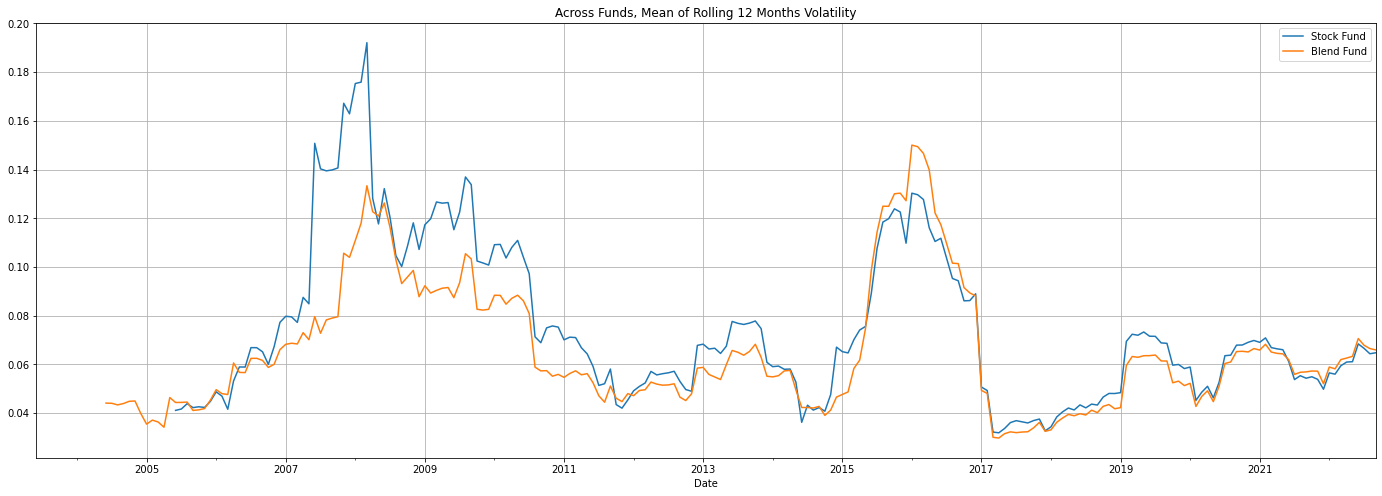

In [87]:
plt.figure(figsize=(24, 8))
rolling_months = 12
(return_of_csmar_stock_fund.unstack(level=0) - 1).rolling(rolling_months).std().mean(axis=1).plot(label='Stock Fund')
(return_of_csmar_blend_fund.unstack(level=0) - 1).rolling(rolling_months).std().mean(axis=1).plot(label='Blend Fund')
plt.grid()
plt.legend()
plt.title(f'Across Funds, Mean of Rolling {rolling_months} Months Volatility')

<AxesSubplot:>

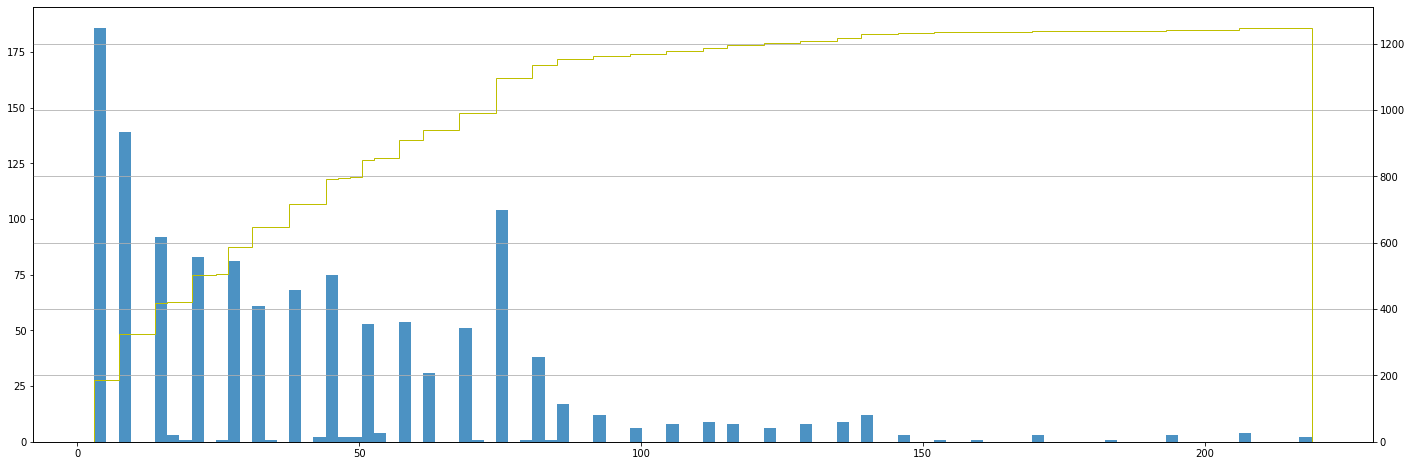

In [88]:
fig, ax = plt.subplots(figsize=(24, 8))
return_of_csmar_stock_fund.unstack(level=0).describe().loc['count'].hist(bins=100, ax=ax, alpha=.8)
ax.grid(False)
ax1 = ax.twinx()
return_of_csmar_stock_fund.unstack(level=0).describe().loc['count'].hist(bins=100, cumulative=True, histtype='step', ax=ax1, color='y')

In [35]:
temp = _

In [37]:
temp.sort_values()

Symbol
011230      3.0
011255      3.0
011254      3.0
011237      3.0
011236      3.0
          ...  
200002    207.0
161604    207.0
050002    207.0
040002    219.0
519180    219.0
Name: count, Length: 1248, dtype: float64

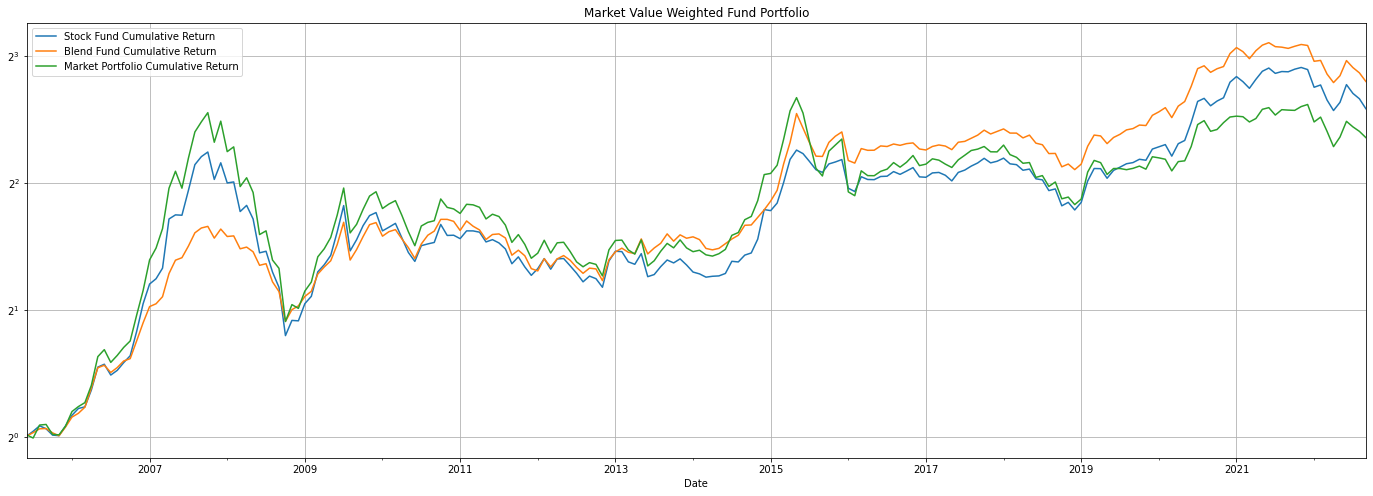

In [19]:
plt.figure(figsize=(24,8))

(((return_of_csmar_stock_fund.unstack(level=0) - 1) * csmar_stock_fund_weight_yearly).sum(axis=1) + 1).loc['2005-6':].cumprod().plot(label='Stock Fund Cumulative Return')
(((return_of_csmar_blend_fund.unstack(level=0) - 1) * csmar_blend_fund_weight_yearly).sum(axis=1) + 1).loc['2005-6':].cumprod().plot(label='Blend Fund Cumulative Return')
((svc_source.loc['2005-6': ].mktrf + svc_source.loc['2005-6': ].rf) + 1).cumprod().plot(label='Market Portfolio Cumulative Return')

plt.yscale('log', base=2)
plt.title('Market Value Weighted Fund Portfolio')
plt.grid()
plt.legend()
plt.show()


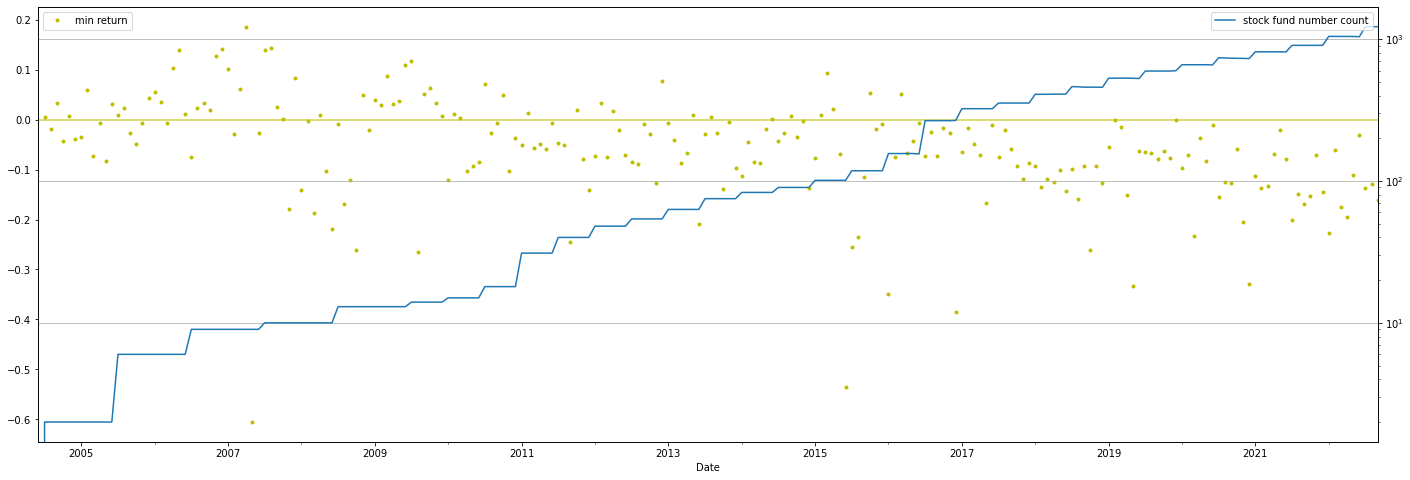

In [20]:
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(24)
(return_of_csmar_stock_fund.unstack(0) - 1).T.describe().loc['min'].plot(ax=ax1, style='.', label='min return', color='y')
ax1.legend()
ax1.legend(loc='upper left')
ax1.axhline(color='y', alpha=.7)
ax2 = ax1.twinx()
(return_of_csmar_stock_fund.unstack(0) - 1).T.describe().loc['count'].plot(ax=ax2, label='stock fund number count')
ax2.grid()
ax2.set_yscale('log')
ax2.legend(loc='upper right')

In [50]:
# plt.figure(figsize=(24,8))
# return_of_stock_fund.groupby(level=1).mean().loc['2005-6':].cumprod().plot(label='Stock Fund Cumulative Return')
# return_of_blend_fund.groupby(level=1).mean().loc['2005-6':].cumprod().plot(label='Blend Fund Cumulative Return')
# plt.yscale('log', base=2)
# plt.title('1/N Weighted Fund Portfolio')
# plt.grid()
# plt.legend()

why use data later than 2005-06?

In [67]:
co_time = np.intersect1d(csmar_share_info.index, csmar_nav_monthly.index)
co_stocks = np.intersect1d(csmar_share_info.columns, csmar_nav_monthly.columns)
compare_share_info = csmar_share_info.loc[co_time, co_stocks]
compare_nav_monthly = csmar_nav_monthly.loc[co_time, co_stocks]

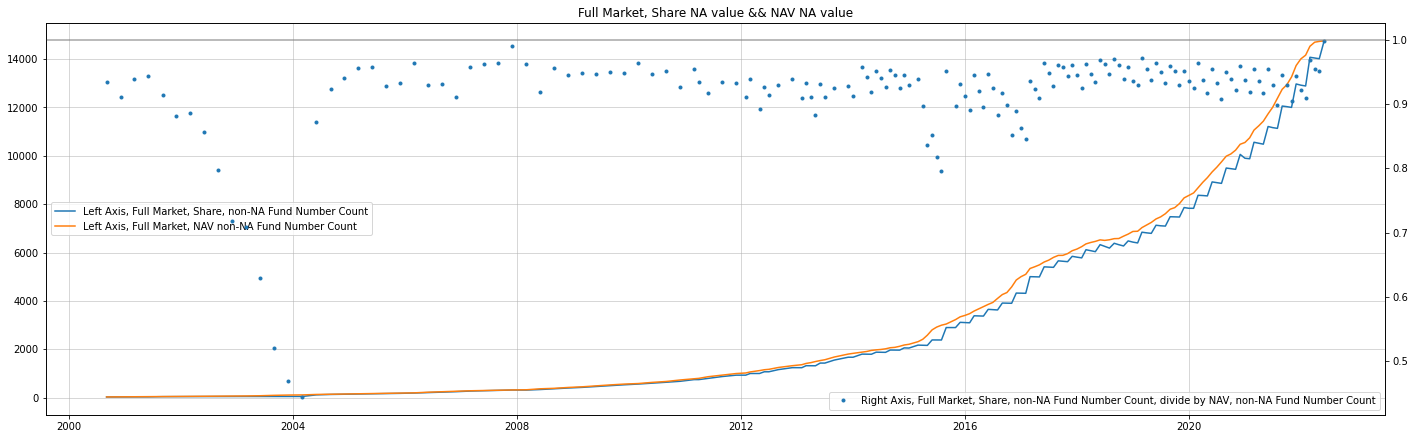

In [68]:
filled_share_info = compare_share_info.fillna(method='ffill')
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(24)
def na_compare(row):
    date = row.name
    available_funds = row.dropna().index
    selected_share_info = (row * filled_share_info.loc[date]).dropna()
    available_share_funds = selected_share_info.index

    return [len(available_share_funds), len(available_funds)]

temp = np.array(list(compare_nav_monthly.apply(na_compare, axis=1).values))
ax1.plot(compare_nav_monthly.index.astype(np.datetime64), temp[:, 0], label='Left Axis, Full Market, Share, non-NA Fund Number Count')
ax1.plot(compare_nav_monthly.index.astype(np.datetime64), temp[:, 1], label='Left Axis, Full Market, NAV non-NA Fund Number Count')
ax1.legend(loc='center left')
ax1.grid(linewidth=.5)

ax2 = ax1.twinx()

pd.Series(temp[:, 0] / temp[:, 1] ,index=compare_nav_monthly.index.astype(np.datetime64)).plot(style='.', label='Right Axis, Full Market, Share, non-NA Fund Number Count, divide by NAV, non-NA Fund Number Count')
plt.title('Full Market, Share NA value && NAV NA value')
ax2.legend(loc='lower right')

ax2.axhline(y=1, color='grey', alpha=.7)


Size effect in fund?

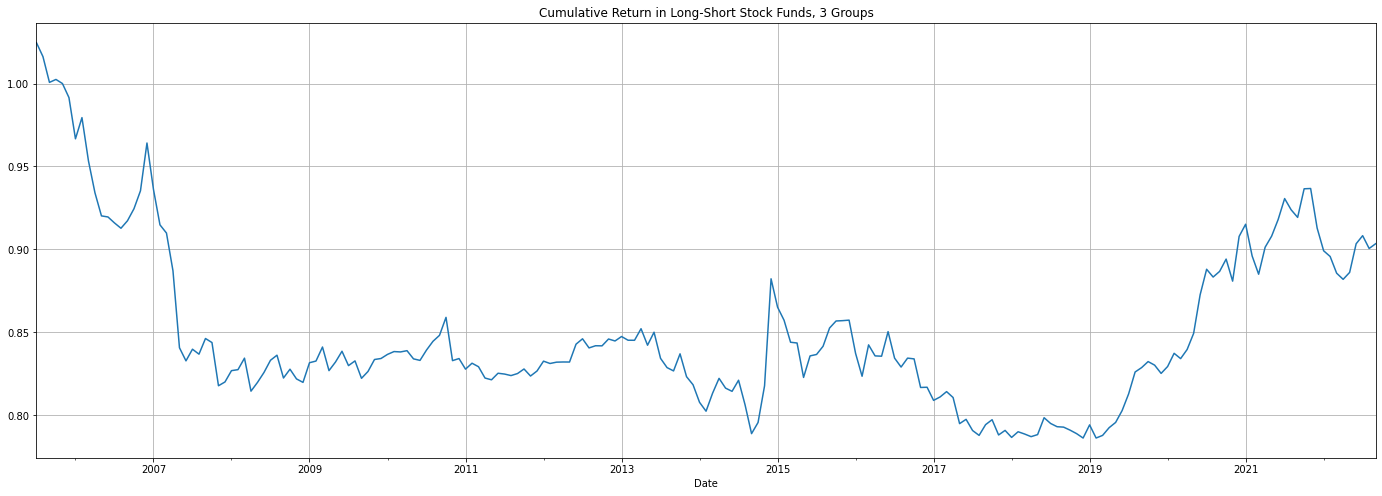

In [69]:
stock_fund_weight_ = (csmar_share_info_yearly.loc[csmar_co_time_6, csmar_stock_code_6] * csmar_nav_yearly.loc[csmar_co_time_6, csmar_stock_code_6])
stock_fund_weight_ = pd.concat([stock_fund_weight_, \
    pd.DataFrame([[np.nan] * stock_fund_weight_.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=stock_fund_weight_.columns)])
stock_fund_weight_ = stock_fund_weight_.resample('M').ffill()

groups = 3
ret_stock_fund = return_of_csmar_stock_fund.unstack(0) - 1
stock_fund_groups = stock_fund_weight_.dropna(how='all').apply(lambda x: pd.qcut(x, groups, labels=np.arange(groups)) if not pd.isna(x).all() else x, axis=1)
co_time = np.intersect1d(stock_fund_groups.index, ret_stock_fund.index)
co_stocks = np.intersect1d(stock_fund_groups.columns, ret_stock_fund.columns)

stock_fund_groups = stock_fund_groups.loc[co_time, co_stocks]
ret_stock_fund = ret_stock_fund.loc[co_time, co_stocks]

def func(x):
    date = x.name
    result = pd.DataFrame([x, stock_fund_groups.loc[date]], index=['return', 'rank']).T.groupby('rank').mean().iloc[:, 0]
    if result.shape[0] < groups:
        
        return pd.Series([np.nan] * groups, name=date)
    else:
        return result

stock_grouped_return = ret_stock_fund.apply(func, axis=1).dropna()
plt.figure(figsize=(24, 8))
plt.title(f'Cumulative Return in Long-Short Stock Funds, {groups} Groups')
(stock_grouped_return.iloc[:, -1] - stock_grouped_return.iloc[:, 0] + 1).cumprod().plot()
plt.grid()

In [70]:
stats.ttest_1samp((stock_grouped_return.iloc[:, -1] - stock_grouped_return.iloc[:, 0]).dropna(), 0, alternative ='greater')

Ttest_1sampResult(statistic=-0.4363630368132899, pvalue=0.6684848318998369)

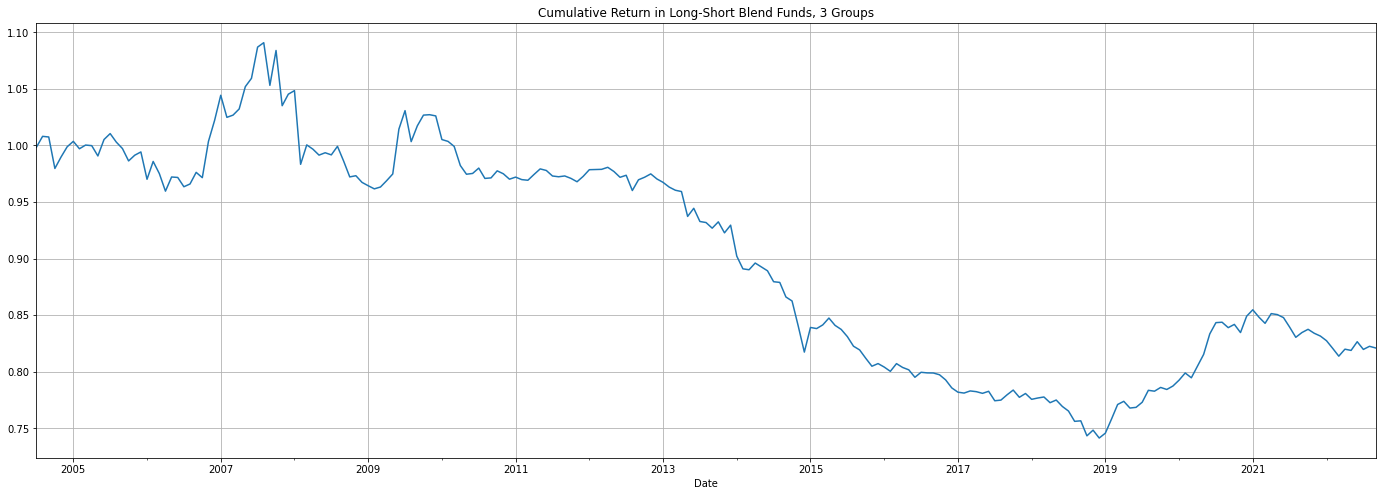

In [71]:
blend_fund_weight_ = (csmar_share_info_yearly.loc[csmar_co_time_6, csmar_blend_code_6] * csmar_nav_yearly.loc[csmar_co_time_6, csmar_blend_code_6])
blend_fund_weight_ = pd.concat([blend_fund_weight_, \
    pd.DataFrame([[np.nan] * blend_fund_weight_.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=blend_fund_weight_.columns)])
blend_fund_weight_ = blend_fund_weight_.resample('M').ffill()

groups = 3
ret_blend_fund = return_of_csmar_blend_fund.unstack(0) - 1
blend_fund_groups = blend_fund_weight_.dropna(how='all').apply(lambda x: pd.qcut(x, groups, labels=np.arange(groups)) if not pd.isna(x).all() else x, axis=1)
co_time = np.intersect1d(blend_fund_groups.index, ret_blend_fund.index)
co_stocks = np.intersect1d(blend_fund_groups.columns, ret_blend_fund.columns)

blend_fund_groups = blend_fund_groups.loc[co_time, co_stocks]
ret_blend_fund = ret_blend_fund.loc[co_time, co_stocks]

def func(x):
    date = x.name
    result = pd.DataFrame([x, blend_fund_groups.loc[date]], index=['return', 'rank']).T.groupby('rank').mean().iloc[:, 0]
    if result.shape[0] < groups:
        
        return pd.Series([np.nan] * groups, name=date)
    else:
        return result
plt.figure(figsize=(24, 8))
plt.title(f'Cumulative Return in Long-Short Blend Funds, {groups} Groups')
blend_grouped_return = ret_blend_fund.apply(func, axis=1).dropna()

(blend_grouped_return.iloc[:, -1] - blend_grouped_return.iloc[:, 0] + 1).cumprod().plot()
plt.grid()

In [72]:
stats.ttest_1samp((blend_grouped_return.iloc[:, -1] - blend_grouped_return.iloc[:, 0]).dropna(), 0, alternative ='greater')

Ttest_1sampResult(statistic=-1.0531885059552117, pvalue=0.85328973176576)

### Regression

In [ ]:
import pickle
import pandas as pd

from data.SVC.svc_source import svc_source
from data.TwoStepData.csmar_blend_fund_weight_yearly import csmar_blend_fund_weight_yearly
from data.TwoStepData.csmar_stock_fund_weight_yearly import csmar_stock_fund_weight_yearly
from data.TwoStepData.return_of_csmar_blend_fund import return_of_csmar_blend_fund
from data.TwoStepData.return_of_csmar_stock_fund import return_of_csmar_stock_fund

regression table construction

In [76]:
stock_fund_regression = ((return_of_csmar_stock_fund.unstack(level=0) - 1) * csmar_stock_fund_weight_yearly).sum(axis=1)
stock_fund_regression.name = 'stock_fund'

blend_fund_regression = ((return_of_csmar_blend_fund.unstack(level=0) - 1) * csmar_blend_fund_weight_yearly).sum(axis=1)
blend_fund_regression.name = 'blend_fund'


regression_source = pd.merge(stock_fund_regression, svc_source[['mktrf', 'rf', 'smb', 'vmg']], on='Date')
regression_source = pd.merge(regression_source, blend_fund_regression, on='Date')

regression_source['α'] = 1

regression_source = regression_source.loc['2005-6':]
regression_source

,stock_fund,mktrf,rf,smb,vmg,blend_fund,α
Date,,,,,,,
2005-06,0.006722,0.011522,0.001856,0.000517,0.056121,0.006346,1
2005-07,0.026240,-0.019041,0.001856,-0.051082,0.071114,0.019213,1
2005-08,0.030586,0.071589,0.001856,0.094712,-0.049516,0.021038,1
2005-09,-0.016050,0.001288,0.001856,0.033242,0.045120,0.001627,1
2005-10,-0.034043,-0.054595,0.001856,-0.001480,0.024557,-0.023199,1
...,...,...,...,...,...,...,...
2022-05,0.045655,0.052554,0.001241,0.064625,-0.012790,0.038071,1
2022-06,0.101454,0.088114,0.001241,-0.020506,-0.028009,0.086118,1
2022-07,-0.046780,-0.030989,0.001241,0.071198,-0.005291,-0.037448,1


naïve regression

In [77]:
stock_naïve = sm.OLS(regression_source.stock_fund, regression_source[['α']]).fit()
blend_naïve = sm.OLS(regression_source.blend_fund, regression_source[['α']]).fit()
stock_naïve_excess = sm.OLS(regression_source.stock_fund - regression_source.rf, regression_source[['α']]).fit()
blend_naïve_excess = sm.OLS(regression_source.blend_fund - regression_source.rf, regression_source[['α']]).fit()


In [78]:
pd.DataFrame(
[
[float_to_percent(stock_naïve.params[0]), stock_naïve.tvalues.iloc[0].round(3), stock_naïve.pvalues[0].round(3), yearly_return(stock_naïve.params[0])],
[float_to_percent(blend_naïve.params[0]), blend_naïve.tvalues.iloc[0].round(3), blend_naïve.pvalues[0].round(3), yearly_return(blend_naïve.params[0])],
[float_to_percent(stock_naïve_excess.params[0]), stock_naïve_excess.tvalues.iloc[0].round(3), stock_naïve_excess.pvalues[0].round(3), yearly_return(stock_naïve_excess.params[0])],
[float_to_percent(blend_naïve_excess.params[0]), blend_naïve_excess.tvalues.iloc[0].round(3), blend_naïve_excess.pvalues[0].round(3), yearly_return(blend_naïve_excess.params[0])],
],
index=['stock_naïve', 'blend_naïve', 'stock_naïve_excess', 'blend_naïve_excess'], columns=pd.Series(['α', 't', 'p', 'annual α'],\
name=f'{regression_source.index[0].year}/{regression_source.index[0].month}-{regression_source.index[-1].year}/{regression_source.index[-1].month}'))

2005/6-2022/9,α,t,p,annual α
stock_naïve,1.091%,2.328,0.021,13.91%
blend_naïve,1.076%,2.930,0.004,13.71%
stock_naïve_excess,0.901%,1.921,0.056,11.36%
blend_naïve_excess,0.886%,2.410,0.017,11.17%


CAPM regression

In [81]:
stock_capm = sm.OLS(regression_source.stock_fund - regression_source.rf, regression_source[['α', 'mktrf']]).fit()
blend_capm = sm.OLS(regression_source.blend_fund - regression_source.rf, regression_source[['α', 'mktrf']]).fit()

In [82]:
pd.DataFrame(
[
[float_to_percent(stock_capm.params[0]) + ' (' + str(stock_capm.tvalues.iloc[0].round(3)) + ')', \
    str(stock_capm.params[1].round(3)) + ' (' + str(stock_capm.tvalues.iloc[1].round(3)) + ')',\
         stock_capm.rsquared, yearly_return(stock_capm.params[0])],
[float_to_percent(blend_capm.params[0]) + ' (' + str(blend_capm.tvalues.iloc[0].round(3)) + ')', \
    str(blend_capm.params[1].round(3)) + ' (' + str(blend_capm.tvalues.iloc[1].round(3)) + ')', \
        blend_capm.rsquared, yearly_return(blend_capm.params[0])],
],
columns=['α', 'mktrf', 'r^2', 'annual α'], index=pd.Series(['stock_capm', 'blend_capm'], \
name=f'{regression_source.index[0].year}/{regression_source.index[0].month}-{regression_source.index[-1].year}/{regression_source.index[-1].month}')).T

2005/6-2022/9,stock_capm,blend_capm
α,0.154% (1.052),0.325% (2.128)
mktrf,0.826 (44.307),0.62 (31.82)
r^2,0.905032,0.830937
annual α,1.86%,3.97%


SVC regression

In [83]:
stock_svc = sm.OLS(regression_source.stock_fund - regression_source.rf, regression_source[['α', 'mktrf', 'smb', 'vmg']]).fit()
blend_svc = sm.OLS(regression_source.blend_fund - regression_source.rf, regression_source[['α', 'mktrf', 'smb', 'vmg']]).fit()

In [84]:
pd.DataFrame(
[
[float_to_percent(stock_svc.params[0]) + ' (' + str(stock_svc.tvalues.iloc[0].round(3)) + ')', \
    str(stock_svc.params[1].round(3)) + ' (' + str(stock_svc.tvalues.iloc[1].round(3)) + ')', \
        str(stock_svc.params[2].round(3)) + ' (' + str(stock_svc.tvalues.iloc[2].round(3)) + ')', \
            str(stock_svc.params[3].round(3)) + ' (' + str(stock_svc.tvalues.iloc[3].round(3)) + ')', \
                stock_svc.rsquared, yearly_return(stock_svc.params[0])],
[float_to_percent(blend_svc.params[0]) + ' (' + str(blend_svc.tvalues.iloc[0].round(3)) + ')', \
    str(blend_svc.params[1].round(3)) + ' (' + str(blend_svc.tvalues.iloc[1].round(3)) + ')', \
        str(blend_svc.params[2].round(3)) + ' (' + str(blend_svc.tvalues.iloc[2].round(3)) + ')', \
            str(blend_svc.params[3].round(3)) + ' (' + str(blend_svc.tvalues.iloc[3].round(3)) + ')', \
                blend_svc.rsquared, yearly_return(blend_svc.params[0])],
],

columns=['α', 'mktrf', 'smb', 'vmg', 'r^2', 'annual α'], index=pd.Series(['stock_svc', 'blend_svc'], \
name=f'{regression_source.index[0].year}/{regression_source.index[0].month}-{regression_source.index[-1].year}/{regression_source.index[-1].month}')).T

2005/6-2022/9,stock_svc,blend_svc
α,0.323% (2.165),0.67% (4.294)
mktrf,0.838 (46.938),0.592 (31.72)
smb,-0.179 (-5.55),-0.063 (-1.867)
vmg,-0.024 (-0.569),-0.263 (-5.967)
r^2,0.919562,0.856929
annual α,3.95%,8.35%


## **V. Fund Evaluation**

### CAPM α

In [1]:
from factors import *
from IPython.display import display


@fund_ended_check
def capm_α_generation(x):
    x = x.dropna()  
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    α = sm.OLS(x - temp_regression.rf, temp_regression[['α', 'mktrf']]).fit().params[0]
    return α

all_fund_capm_α = return_of_all_fund_.loc['2005-6': '2019-6'].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(capm_α_generation)

all_fund_capm_α.shape

(169, 5286)

In [2]:
group_and_statistic(all_fund_capm_α, groups=5, weighting='mkt', interval=1)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.985%  1.122%  1.103%  1.272%  1.291%     0.306%
       annual α     12.48%  14.32%  14.07%  16.37%  16.64%      3.73%
       t             1.722   1.965   1.958   2.229   2.186      1.715
       R^2             0.0     0.0    -0.0    -0.0     0.0       -0.0
       Obs             168     168     168     168     168        168
capm α α (monthly)  0.114%   0.26%  0.259%  0.471%  0.446%     0.332%
       annual α      1.38%   3.17%   3.16%    5.8%   5.48%      4.05%
       t             0.781   1.589   1.486   1.805   1.799      1.847
       R^2           0.936   0.919   0.906   0.795   0.827      0.008
       Obs             168     168     168     168     168        168
svc α  α (monthly)  0.112%  0.341%    0.4%  0.504%  0.686%     0.574%
       annual α      1.35%   4.16%    4.9%   6.22%   8.55%      7.11%
       t             0.668   1.804   2.051   1.658   2.516      2.883
       R^2           0.939   0.922   0.914   0.796   0.847      0.106
       Obs             168     168     168     168     168        168

In [3]:
group_and_statistic(all_fund_capm_α, groups=5, weighting='mkt', interval=3)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.184%  1.335%  1.323%  1.568%  1.425%     0.247%
       annual α     15.17%  17.25%  17.08%  20.53%  18.51%      3.01%
       t             1.755   1.953   2.023   2.165   2.142      1.582
       R^2            -0.0    -0.0     0.0    -0.0     0.0       -0.0
       Obs              56      56      56      56      56         56
capm α α (monthly)  0.972%  1.127%  1.129%  1.395%  1.237%      0.27%
       annual α     12.31%  14.39%  14.42%  18.08%   15.9%      3.29%
       t             1.673   1.892   1.965   2.075   2.085      1.762
       R^2            0.28   0.263    0.25   0.164   0.228       0.06
       Obs              56      56      56      56      56         56
svc α  α (monthly)   0.34%  0.472%   0.57%  0.564%  0.739%     0.402%
       annual α      4.15%   5.81%   7.06%   6.98%   9.24%      4.94%
       t             0.484   0.661   0.818   0.699   1.016      2.278
       R^2           0.325    0.32   0.289   0.228   0.251      0.187
       Obs              56      56      56      56      56         56

### SVC α

In [4]:
from factors import *
from IPython.display import display

@fund_ended_check
def svc_α_generation(x):
    x = x.dropna()  
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    α = sm.OLS(x - temp_regression.rf, temp_regression[['α', 'mktrf', 'smb', 'vmg']]).fit().params[0]
    return α

all_fund_svc_α = return_of_all_fund_.loc['2005-6': '2019-6'].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(svc_α_generation)

all_fund_svc_α.shape

(169, 5286)

In [5]:
group_and_statistic(all_fund_svc_α, groups=5, weighting='mkt', interval=1)

group0  group1  group2  group3  group4 long-short
excess α (monthly)   0.996%  1.083%  1.153%  1.298%  1.257%     0.261%
       annual α      12.63%   13.8%  14.75%  16.73%  16.17%      3.18%
       t              1.725   1.888   2.069   2.201    2.17      1.594
       R^2             -0.0     0.0     0.0    -0.0     0.0        0.0
       Obs              168     168     168     168     168        168
capm α α (monthly)    0.12%  0.214%  0.316%   0.49%  0.422%     0.301%
       annual α       1.45%    2.6%   3.86%   6.04%   5.18%      3.68%
       t              0.778   1.364   1.882   1.673   1.803      1.842
       R^2             0.93   0.927   0.911   0.758    0.84      0.024
       Obs              168     168     168     168     168        168
svc α  α (monthly)  -0.014%  0.202%  0.439%  0.561%  0.722%     0.736%
       annual α      -0.17%   2.45%    5.4%   6.95%   9.02%       9.2%
       t             -0.079   1.117    2.31   1.649   2.838       4.46
       R^2            0.932   0.929   0.917   0.761   0.862      0.273
       Obs              168     168     168     168     168        168

In [6]:
group_and_statistic(all_fund_svc_α, groups=5, weighting='mkt', interval=3)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.311%  1.321%  1.307%  1.465%  1.392%     0.084%
       annual α     16.91%  17.06%  16.87%  19.06%  18.05%      1.01%
       t             1.937   1.959   2.013   2.072   2.068      0.517
       R^2             0.0    -0.0    -0.0     0.0     0.0        0.0
       Obs              56      56      56      56      56         56
capm α α (monthly)    1.1%  1.115%   1.11%   1.29%  1.198%       0.1%
       annual α     14.03%  14.23%  14.16%  16.63%  15.36%      1.21%
       t             1.882   1.901   1.961    1.98   2.008       0.62
       R^2           0.275   0.265   0.262   0.173   0.237      0.029
       Obs              56      56      56      56      56         56
svc α  α (monthly)  0.378%  0.453%  0.558%  0.544%    0.7%     0.325%
       annual α      4.63%   5.57%   6.91%   6.73%   8.73%      3.97%
       t             0.543   0.642   0.814   0.695   0.957      1.916
       R^2           0.341   0.317   0.302   0.234    0.26      0.299
       Obs              56      56      56      56      56         56

### CAPM α/ε

In [7]:
from factors import *
from IPython.display import display

@fund_ended_check
def capm_α_ε_generation(x):
    x = x.dropna()  
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    result = sm.OLS(x - temp_regression.rf, temp_regression[['α', 'mktrf']]).fit()
    α = result.params[0]
    ε = result.resid.std()
    division = α / ε

    if division < 1e3 and division > 1e-3:
        return division
    else:
        return np.nan

all_fund_capm_α_ε = return_of_all_fund_.loc['2005-6': '2019-6'].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(capm_α_ε_generation)

all_fund_capm_α_ε.shape

(169, 5286)

In [8]:
group_and_statistic(all_fund_capm_α_ε, groups=5, weighting='mkt', interval=1)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.084%  1.105%  1.141%  1.403%  1.338%     0.254%
       annual α     13.82%   14.1%  14.59%  18.19%  17.29%      3.09%
       t              1.82   1.916    2.02   2.246   2.359      2.098
       R^2            -0.0    -0.0     0.0     0.0     0.0       -0.0
       Obs             166     166     166     166     166        166
capm α α (monthly)  0.218%  0.274%  0.334%  0.628%  0.537%     0.319%
       annual α      2.64%   3.33%   4.08%    7.8%   6.64%       3.9%
       t             1.178   1.416   1.657   1.706   2.455      2.795
       R^2           0.906    0.89   0.876    0.66   0.854      0.126
       Obs             166     166     166     166     166        166
svc α  α (monthly)  0.346%  0.413%  0.445%  0.511%  0.732%     0.387%
       annual α      4.23%   5.07%   5.47%   6.31%   9.15%      4.74%
       t             1.674   1.945   1.989   1.194   3.039      2.944
       R^2           0.913   0.902   0.887   0.661    0.87      0.149
       Obs             166     166     166     166     166        166

In [9]:
group_and_statistic(all_fund_capm_α_ε, groups=5, weighting='mkt', interval=3)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.269%  1.287%  1.679%  1.357%  1.507%     0.244%
       annual α     16.34%  16.59%  22.11%  17.55%  19.67%      2.97%
       t             1.784   1.891   2.146   2.075   2.288      1.941
       R^2             0.0     0.0     0.0     0.0     0.0        0.0
       Obs              55      55      55      55      55         55
capm α α (monthly)  1.056%  1.084%  1.507%  1.171%  1.307%     0.256%
       annual α     13.43%  13.82%  19.67%   15.0%  16.86%      3.12%
       t             1.696   1.818   2.046   2.012   2.281      2.038
       R^2           0.257   0.254   0.138    0.23   0.266      0.026
       Obs              55      55      55      55      55         55
svc α  α (monthly)  0.534%  0.527%  0.583%    0.6%  0.825%     0.294%
       annual α       6.6%   6.51%   7.22%   7.44%  10.37%      3.59%
       t             0.711   0.732   0.669   0.854   1.187      2.073
       R^2            0.29   0.288   0.216   0.266    0.29      0.179
       Obs              55      55      55      55      55         55

### SVC α/ε

In [10]:
from factors import *
from IPython.display import display

@fund_ended_check
def svc_α_ε_generation(x):
    x = x.dropna()  
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    result = sm.OLS(x - temp_regression.rf, temp_regression[['α', 'mktrf', 'smb', 'vmg']]).fit()
    α = result.params[0]
    ε = result.resid.std()
    division = α / ε
    if division < 1e3 and division > 1e-3:
        return division
    else:
        return np.nan

all_fund_svc_α_ε = return_of_all_fund_.loc['2005-6': '2019-6'].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(svc_α_ε_generation)

all_fund_svc_α_ε.shape

(169, 5286)

In [11]:
group_and_statistic(all_fund_svc_α_ε, groups=5, weighting='mkt', interval=1)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.084%  1.083%  1.123%  1.379%   1.32%     0.236%
       annual α     13.81%   13.8%  14.34%  17.86%  17.05%      2.87%
       t             1.856   1.895   1.917   2.223   2.231      1.823
       R^2             0.0     0.0     0.0     0.0    -0.0        0.0
       Obs             164     164     164     164     164        164
capm α α (monthly)  0.201%  0.238%  0.253%  0.565%  0.454%     0.253%
       annual α      2.44%   2.89%   3.08%    7.0%   5.59%      3.08%
       t             1.171   1.168   1.256   1.619   2.019      1.937
       R^2           0.915   0.875   0.884    0.69   0.859      0.007
       Obs             164     164     164     164     164        164
svc α  α (monthly)    0.3%  0.341%  0.442%  0.491%  0.791%     0.491%
       annual α      3.66%   4.17%   5.43%   6.06%   9.92%      6.06%
       t             1.544   1.507   1.986   1.215   3.309      3.537
       R^2            0.92   0.886   0.895   0.691   0.881      0.166
       Obs             164     164     164     164     164        164

In [12]:
group_and_statistic(all_fund_svc_α_ε, groups=5, weighting='mkt', interval=3)

group0  group1  group2  group3  group4 long-short
excess α (monthly)   1.32%  1.305%  1.712%  1.304%  1.418%     0.101%
       annual α     17.04%  16.83%  22.59%  16.82%  18.41%      1.22%
       t             1.904   1.899   2.006   1.974   2.023      0.865
       R^2             0.0     0.0     0.0     0.0     0.0        0.0
       Obs              54      54      54      54      54         54
capm α α (monthly)  1.135%  1.125%  1.564%  1.132%  1.232%     0.099%
       annual α     14.51%  14.37%  20.46%  14.46%  15.83%      1.19%
       t             1.883   1.871    1.92   1.957    2.02      0.835
       R^2           0.264   0.255   0.114   0.255   0.264      0.002
       Obs              54      54      54      54      54         54
svc α  α (monthly)  0.584%  0.531%  0.524%  0.606%   0.75%     0.168%
       annual α      7.23%   6.56%   6.48%   7.53%   9.38%      2.04%
       t             0.807    0.74   0.551   0.873   1.021      1.175
       R^2           0.299   0.297   0.205   0.288   0.291      0.018
       Obs              54      54      54      54      54         54

### IC : Industry Concentration

In [13]:
import pandas as pd
from data.CSMAR.TRD_Mnth import csmar_monthly_stock
from data.TwoStepData.invest_detail import invest_detail
from data.TwoStepData.return_of_all_fund import return_of_all_fund
from data.JoinQuant.jq_stock_classification import jq_stock_classification

auth success 


In [14]:
return_of_all_fund_ = (return_of_all_fund.unstack(0) - 1).loc['2005-6': '2019-6']

invest_detail_ = pd.merge(invest_detail, jq_stock_classification[['Stkcd', 'Indnme']], on='Stkcd', validate='m:1')

month_mkt_value_ = pd.merge(csmar_monthly_stock, jq_stock_classification, on='Stkcd', validate='m:1')
month_mkt_value_ = month_mkt_value_.groupby(['Date', 'Indnme']).apply(lambda x: x.Msmvttl.sum())
month_mkt_value_ = month_mkt_value_.unstack().div(month_mkt_value_.unstack().sum(axis=1), axis=0).fillna(0)


In [15]:
invest_industry_sum = invest_detail_.groupby(['Symbol', 'Date', 'Indnme']).apply(lambda x: x.Proportion.sum())

invest_industry_proportion = invest_industry_sum / invest_industry_sum.groupby(level=[0, 1]).sum()
invest_industry_proportion = invest_industry_proportion.unstack(level=[0, 2]).resample('M').ffill().fillna(method='ffill')
invest_industry_proportion = invest_industry_proportion.stack(0).swaplevel().sort_index().fillna(0)

month_mkt_value_ = pd.merge(invest_industry_proportion.reset_index()[['Symbol', 'Date']], month_mkt_value_, on='Date')\
    .set_index(['Symbol', 'Date']).sort_index()

In [16]:
industry_concentration = ((invest_industry_proportion - month_mkt_value_) ** 2).sum(axis=1)
industry_concentration = industry_concentration.unstack().T.loc['2005-6': '2019-6']

co_funds = np.intersect1d(industry_concentration.columns, return_of_all_fund_.columns)
industry_concentration = industry_concentration[co_funds]

industry_concentration.shape

(169, 939)

In [17]:
group_and_statistic(industry_concentration, groups=5, weighting='mkt', interval=1)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.201%  1.426%  1.028%  1.039%  1.143%    -0.058%
       annual α     15.41%  18.53%  13.06%   13.2%  14.61%      -0.7%
       t             2.108   2.285   1.822   1.836   1.937     -0.354
       R^2             0.0    -0.0     0.0     0.0     0.0       -0.0
       Obs             168     168     168     168     168        168
capm α α (monthly)  0.337%  0.605%   0.19%  0.201%  0.278%     -0.06%
       annual α      4.13%    7.5%   2.31%   2.44%   3.39%     -0.71%
       t             2.181    1.75   1.007   1.039   1.283     -0.358
       R^2           0.928     0.7    0.89   0.886   0.868        0.0
       Obs             168     168     168     168     168        168
svc α  α (monthly)  0.342%  0.433%  0.323%  0.421%  0.374%     0.032%
       annual α      4.19%   5.32%   3.95%   5.17%   4.58%      0.38%
       t             1.901   1.074    1.51   1.965   1.564      0.174
       R^2           0.928   0.701   0.897   0.897   0.882       0.12
       Obs             168     168     168     168     168        168

In [18]:
group_and_statistic(industry_concentration, groups=5, weighting='mkt', interval=3)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.359%  1.609%  1.226%  1.242%  1.356%    -0.004%
       annual α     17.59%  21.12%  15.75%  15.97%  17.54%     -0.04%
       t             2.063   2.112   1.888   1.902   1.964     -0.021
       R^2            -0.0     0.0     0.0    -0.0     0.0        0.0
       Obs              56      56      56      56      56         56
capm α α (monthly)  1.152%  1.434%  1.028%  1.053%  1.145%    -0.007%
       annual α     14.73%  18.63%  13.06%   13.4%  14.63%     -0.08%
       t             2.034   2.014   1.818    1.82   1.908     -0.041
       R^2           0.283   0.152   0.263   0.237   0.266      0.001
       Obs              56      56      56      56      56         56
svc α  α (monthly)  0.582%  0.472%  0.436%  0.518%  0.574%    -0.008%
       annual α      7.21%   5.81%   5.36%   6.39%   7.11%     -0.09%
       t             0.855   0.557   0.639   0.733   0.782     -0.041
       R^2           0.333   0.232   0.307   0.267   0.293      0.192
       Obs              56      56      56      56      56         56

### AS : Active Share

In [19]:
import numpy as np

from IPython.display import display
from factors import *
from data.CSMAR.index_weight import *
from data.TwoStepData.invest_detail import invest_detail
from data.TwoStepData.return_of_all_fund import return_of_all_fund
from data.JoinQuant.jq_stock_classification import jq_stock_classification

In [ ]:
return_of_all_fund_ = (return_of_all_fund.unstack(0) - 1).loc['2005-6': '2019-6']

invest_detail_ = pd.merge(invest_detail, jq_stock_classification[['Stkcd', 'Indnme']], on='Stkcd', validate='m:1')

In [ ]:
invest_detail_ = invest_detail_.drop_duplicates(['Symbol', 'Date', 'Stkcd'])
invest_detail_ = invest_detail_[invest_detail_.Date >= '2005-6']
invest_detail_ = invest_detail_.pivot(index=['Symbol', 'Date'], columns='Stkcd', values='Proportion')
invest_detail_ = invest_detail_.div(invest_detail_.sum(axis=1), axis=0) * 100


In [ ]:
hs300_weight_in_csmar_form = pd.DataFrame(columns=csmar_hs300_weight.columns, index=invest_detail_.index, \
    data=pd.merge(csmar_hs300_weight, pd.Series(invest_detail_.index.get_level_values(1).values, name='Enddt'), on='Enddt', how='right').iloc[:, 1:].values)

hs300_co_stocks = np.intersect1d(invest_detail_.columns, hs300_weight_in_csmar_form.columns)
hs300_AS = (np.abs(hs300_weight_in_csmar_form[hs300_co_stocks] - invest_detail_[hs300_co_stocks])).sum(axis=1) / 2

sz50_weight_in_csmar_form = pd.DataFrame(columns=csmar_sz50_weight.columns, index=invest_detail_.index, \
    data=pd.merge(csmar_sz50_weight, pd.Series(invest_detail_.index.get_level_values(1).values, name='Enddt'), on='Enddt', how='right').iloc[:, 1:].values)

sz50_co_stocks = np.intersect1d(invest_detail_.columns, csmar_sz50_weight.columns)
sz50_AS = (np.abs(sz50_weight_in_csmar_form[sz50_co_stocks] - invest_detail_[sz50_co_stocks])).sum(axis=1) / 2

zz500_weight_in_csmar_form = pd.DataFrame(columns=csmar_zz500_weight.columns, index=invest_detail_.index, \
    data=pd.merge(csmar_zz500_weight, pd.Series(invest_detail_.index.get_level_values(1).values, name='Enddt'), on='Enddt', how='right').iloc[:, 1:].values)

zz500_co_stocks = np.intersect1d(invest_detail_.columns, csmar_zz500_weight.columns)
zz500_AS = (np.abs(zz500_weight_in_csmar_form[zz500_co_stocks] - invest_detail_[zz500_co_stocks])).sum(axis=1) / 2

In [ ]:
active_share = pd.concat([hs300_AS, zz500_AS, sz50_AS], axis=1).replace(0, np.inf).min(axis=1).unstack(0)
co_funds = np.intersect1d(active_share.columns, return_of_all_fund_.columns)
active_share = active_share[co_funds].replace(np.inf, np.nan).loc['2005-6' : '2019-6'].dropna(how='all', axis=1).apply(lambda x: x[:x[pd.notna(x)].index[-1]].ffill())
active_share.shape

(72, 772)

In [ ]:
group_and_statistic(active_share, groups=5, weighting='mkt', interval=1)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.179%  1.079%  1.174%  1.306%  1.002%    -0.177%
       annual α      15.1%  13.74%  15.03%  16.85%  12.71%      -2.1%
       t             2.099   1.904   2.043   2.184   1.736     -1.794
       R^2             0.0    -0.0    -0.0    -0.0     0.0       -0.0
       Obs             168     168     168     168     168        168
capm α α (monthly)  0.338%  0.236%  0.323%  0.494%  0.125%    -0.213%
       annual α      4.13%   2.87%   3.94%    6.1%   1.51%     -2.53%
       t             1.934   1.262   1.651   1.618   0.824     -2.201
       R^2           0.905   0.893   0.887   0.744   0.932      0.055
       Obs             168     168     168     168     168        168
svc α  α (monthly)  0.468%  0.419%  0.379%  0.369%  0.261%    -0.207%
       annual α      5.76%   5.15%   4.64%   4.52%   3.18%     -2.45%
       t             2.347   2.002    1.76   1.037     1.5     -1.842
       R^2            0.91   0.902   0.899   0.746   0.935      0.071
       Obs             168     168     168     168     168        168

In [ ]:
group_and_statistic(active_share, groups=5, weighting='mkt', interval=3)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.386%  1.271%  1.329%  1.553%  1.202%    -0.189%
       annual α     17.96%  16.36%  17.17%  20.32%  15.42%     -2.24%
       t             2.072   1.974   2.053   2.075   1.801      -2.09
       R^2             0.0     0.0     0.0     0.0     0.0        0.0
       Obs              56      56      56      56      56         56
capm α α (monthly)  1.185%  1.078%  1.135%  1.378%  0.985%    -0.205%
       annual α     15.18%  13.73%   14.5%  17.85%  12.48%     -2.43%
       t             2.026   1.911   2.003   1.976   1.739     -2.347
       R^2           0.257   0.254   0.256   0.157     0.3      0.088
       Obs              56      56      56      56      56         56
svc α  α (monthly)  0.584%  0.525%   0.58%  0.421%  0.472%    -0.114%
       annual α      7.24%   6.49%   7.18%   5.17%   5.82%     -1.35%
       t             0.827   0.766   0.839   0.506   0.688     -1.076
       R^2           0.301    0.29   0.287   0.234   0.338       0.13
       Obs              56      56      56      56      56         56

### $CCP_{SVC}$ : Connected Companies Portfolio

In [121]:
import numpy as np
import pandas as pd
import dask.array as da
from data.TwoStepData.invest_detail import invest_detail
from data.TwoStepData.filtered_funds import filtered_funds

In [122]:
invest_detail = invest_detail[invest_detail.Date.between('2005-6', '2019-6')]
v_mnt = invest_detail.pivot(index=['Date', 'Stkcd'], columns='Symbol', values='Proportion')
invest_detail_matrix = v_mnt.values.copy()
invest_detail_matrix[np.isnan(invest_detail_matrix)] = 0
proportion_sum = da.array(invest_detail_matrix).sum(axis=1).compute()

v_mnt = v_mnt.loc[proportion_sum != 0]
proportion_sum = proportion_sum[proportion_sum != 0]
v_mnt = pd.DataFrame(index=v_mnt.index, columns=v_mnt.columns, data=v_mnt.values / proportion_sum.reshape(-1, 1))



In [123]:
from factors import *
from IPython.display import display
@fund_ended_check
def svc_α_ε_generation(x):
    x = x.dropna()  
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    result = sm.OLS(x - temp_regression.rf, temp_regression[['α', 'mktrf', 'smb', 'vmg']]).fit()
    α = result.params[0]
    ε = result.resid.std()
    division = α / ε
    if division < 1e3 and division > 1e-3:
        return division
    else:
        return np.nan

all_fund_svc_α_ε = return_of_all_fund_.loc['2005-6': '2019-6'].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(svc_α_ε_generation)

In [124]:
a_mt = pd.merge(pd.Series(index=v_mnt.index.get_level_values(0), data=[np.nan] * len(v_mnt.index), name='temp'), all_fund_svc_α_ε, on='Date', how='left')

co_funds = np.intersect1d(a_mt.columns, v_mnt.columns)
δ_nt = da.array(v_mnt[co_funds].fillna(0).values * a_mt[co_funds].fillna(0).values).sum(axis=1).compute()
δ_nt = pd.Series(index=v_mnt.index, data=δ_nt)

w_int = invest_detail.pivot(index=['Date', 'Stkcd'], columns='Symbol', values='Proportion')
ccp_svc_it = w_int.loc[δ_nt.index].multiply(δ_nt, axis=0).groupby(level=0).sum().replace(0, np.nan).dropna(how='all', axis=1).apply(lambda x: x[:x[pd.notna(x)].index[-1]].ffill())

In [125]:
group_and_statistic(ccp_svc_it, groups=5, weighting='mkt', interval=1)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.951%   1.09%   1.04%  1.156%  1.262%      0.31%
       annual α     12.03%   13.9%  13.22%  14.78%  16.24%      3.79%
       t             1.804   1.878   1.785   1.926   1.972      1.196
       R^2             0.0     0.0    -0.0     0.0    -0.0       -0.0
       Obs             162     162     162     162     162        162
capm α α (monthly)  0.181%  0.274%  0.193%  0.281%   0.34%      0.16%
       annual α      2.19%   3.33%   2.35%   3.42%   4.16%      1.93%
       t             1.062   1.138   0.978   1.418   1.467      0.657
       R^2           0.898   0.832   0.887   0.893   0.871      0.142
       Obs             162     162     162     162     162        162
svc α  α (monthly)  0.086%  0.133%  0.364%  0.482%  0.618%     0.532%
       annual α      1.03%    1.6%   4.45%   5.95%   7.68%      6.58%
       t             0.443   0.477    1.66   2.198   2.474       1.97
       R^2           0.902   0.833   0.897   0.903   0.889      0.211
       Obs             162     162     162     162     162        162

In [126]:
group_and_statistic(ccp_svc_it.dropna(how='all', axis=1).apply(lambda x: x[:x[pd.notna(x)].index[-1]].ffill()), groups=5, weighting='mkt', interval=3)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.133%  1.295%  1.251%  1.377%  1.459%     0.333%
       annual α     14.48%   16.7%  16.09%  17.84%  18.98%      4.07%
       t             1.851   1.828   1.836   1.942   1.997      1.219
       R^2             0.0     0.0     0.0     0.0    -0.0        0.0
       Obs              54      54      54      54      54         54
capm α α (monthly)  0.961%  1.137%  1.077%  1.193%  1.262%     0.307%
       annual α     12.16%  14.53%  13.72%  15.29%  16.24%      3.75%
       t             1.844   1.755   1.793   1.919   1.995      1.131
       R^2           0.296   0.187   0.244   0.252   0.271      0.032
       Obs              54      54      54      54      54         54
svc α  α (monthly)  0.199%  0.286%  0.552%  0.682%  0.785%     0.589%
       annual α      2.42%   3.49%   6.82%    8.5%   9.84%       7.3%
       t              0.33   0.382   0.765   0.914   1.027      1.839
       R^2           0.378   0.284   0.279   0.284   0.292      0.096
       Obs              54      54      54      54      54         54

### $CCP_{CAPM}$ : Connected Companies Portfolio

In [127]:
import numpy as np
import pandas as pd
from factors import *
import dask.array as da
from data.TwoStepData.invest_detail import invest_detail
from data.TwoStepData.filtered_funds import filtered_funds

In [128]:
invest_detail = invest_detail[invest_detail.Date.between('2005-6', '2019-6')]
v_mnt = invest_detail.pivot(index=['Date', 'Stkcd'], columns='Symbol', values='Proportion')
invest_detail_matrix = v_mnt.values.copy()
invest_detail_matrix[np.isnan(invest_detail_matrix)] = 0
proportion_sum = da.array(invest_detail_matrix).sum(axis=1).compute()

v_mnt = v_mnt.loc[proportion_sum != 0]
proportion_sum = proportion_sum[proportion_sum != 0]
v_mnt = pd.DataFrame(index=v_mnt.index, columns=v_mnt.columns, data=v_mnt.values / proportion_sum.reshape(-1, 1))



In [129]:
@fund_ended_check
def capm_α_ε_generation(x):
    x = x.dropna()  
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    result = sm.OLS(x - temp_regression.rf, temp_regression[['α', 'mktrf']]).fit()
    α = result.params[0]
    ε = result.resid.std()
    division = α / ε
    if division < 1e3 and division > 1e-3:
        return division
    else:
        return np.nan

all_fund_capm_α_ε = return_of_all_fund_.loc['2005-6': '2019-6'].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(capm_α_ε_generation)

In [130]:
a_mt = pd.merge(pd.Series(index=v_mnt.index.get_level_values(0), data=[np.nan] * len(v_mnt.index), name='temp'), all_fund_capm_α_ε, on='Date', how='left')

co_funds = np.intersect1d(a_mt.columns, v_mnt.columns)
δ_nt = da.array(v_mnt[co_funds].fillna(0).values * a_mt[co_funds].fillna(0).values).sum(axis=1).compute()
δ_nt = pd.Series(index=v_mnt.index, data=δ_nt)

w_int = invest_detail.pivot(index=['Date', 'Stkcd'], columns='Symbol', values='Proportion')
ccp_capm_it = w_int.loc[δ_nt.index].multiply(δ_nt, axis=0).groupby(level=0).sum().replace(0, np.nan).dropna(how='all', axis=1).apply(lambda x: x[:x[pd.notna(x)].index[-1]].ffill())

In [131]:
group_and_statistic(ccp_capm_it, groups=5, weighting='mkt', interval=1)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.767%  1.254%  1.066%  1.133%  1.319%     0.552%
       annual α       9.6%  16.13%  13.57%  14.47%  17.02%      6.83%
       t             1.487   2.063   1.868   1.884   2.122      2.344
       R^2             0.0     0.0     0.0    -0.0     0.0        0.0
       Obs             165     165     165     165     165        165
capm α α (monthly)  0.018%  0.448%  0.241%  0.272%  0.426%     0.408%
       annual α      0.22%   5.51%   2.93%   3.32%   5.24%      5.01%
       t             0.114   1.472   1.302   1.285   2.001      1.872
       R^2           0.904   0.754   0.897   0.878   0.885       0.16
       Obs             165     165     165     165     165        165
svc α  α (monthly)  0.072%  0.265%  0.347%  0.468%  0.604%     0.532%
       annual α      0.87%   3.23%   4.25%   5.76%    7.5%      6.57%
       t             0.393   0.753   1.678   2.015   2.554      2.127
       R^2           0.908   0.756   0.904   0.892   0.895       0.18
       Obs             165     165     165     165     165        165

In [132]:
group_and_statistic(ccp_capm_it.dropna(how='all', axis=1).apply(lambda x: x[:x[pd.notna(x)].index[-1]].ffill()), groups=5, weighting='mkt', interval=3)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.939%  1.494%  1.275%   1.34%  1.521%     0.593%
       annual α     11.87%  19.48%  16.42%  17.32%  19.86%      7.35%
       t             1.599   1.976   1.917   1.923   2.096      2.244
       R^2             0.0     0.0     0.0     0.0     0.0        0.0
       Obs              55      55      55      55      55         55
capm α α (monthly)  0.747%  1.315%  1.083%  1.142%  1.296%     0.557%
       annual α      9.34%  16.98%  13.79%   14.6%   16.7%      6.89%
       t             1.502   1.871   1.839   1.841   2.069      2.137
       R^2           0.304    0.16   0.239    0.23   0.277      0.053
       Obs              55      55      55      55      55         55
svc α  α (monthly)  0.051%  0.411%  0.508%  0.629%  0.792%     0.741%
       annual α      0.62%   5.04%   6.27%   7.81%   9.93%      9.27%
       t             0.088   0.498   0.719   0.837   1.041      2.386
       R^2           0.381   0.249   0.281   0.259     0.3      0.105
       Obs              55      55      55      55      55         55

### RG : Return Gap

In [133]:
import numpy as np
import pandas as pd
from factors import *
import dask.array as da
from data.CSMAR.fees import csmar_fees
from data.CSMAR.TRD_Mnth import csmar_monthly_stock
from data.TwoStepData.invest_detail import invest_detail
from data.TwoStepData.filtered_funds import filtered_funds
from data.TwoStepData.return_of_all_fund import return_of_all_fund

In [134]:
fees = csmar_fees.groupby(['Symbol', 'Date']).apply(lambda x: x.ProportionOfFee.sum())
fees_filtered = fees.reset_index().rename(columns={0: 'fees'}).pivot(index='Date', columns='Symbol', values='fees')
co_time = np.intersect1d(fees_filtered.index, filtered_funds.index)
co_funds = np.intersect1d(fees_filtered.columns, filtered_funds.columns)
fees_filtered = fees_filtered.loc[co_time, co_funds][filtered_funds.loc[co_time, co_funds]].stack()

In [154]:
return_gap = pd.merge(invest_detail, fees_filtered.reset_index().rename(columns={0: 'fees'}), on=['Date', 'Symbol'])
return_gap = pd.merge(return_gap, csmar_monthly_stock, on=['Date', 'Stkcd'])
return_gap['Symbol'] = return_gap.Symbol.str.zfill(6)
return_gap = pd.merge(return_gap, return_of_all_fund.reset_index(), on=['Date', 'Symbol'])

return_gap['Proportion'] = return_gap[['Date', 'Symbol', 'Proportion']].groupby(['Date', 'Symbol']).apply(lambda x: x.Proportion / x.Proportion.sum()).values
# rh_minus_exp_t = return_gap.groupby(['Date', 'Symbol']).apply(lambda x: (x.Proportion * x.Mretwd).sum() - x.fees.iloc[0] / 100)
rh_minus_exp_t = return_gap.groupby(['Date', 'Symbol']).apply(lambda x: (x.Proportion * x.Mretwd).sum() / 100)
rf_return_of_fund = return_gap.groupby(['Date', 'Symbol']).last().return_of_all_fund
return_gap = rf_return_of_fund - rh_minus_exp_t
rg_t = return_gap.unstack().resample('M').ffill().dropna(how='all', axis=1).apply(lambda x: x[:x[pd.notna(x)].index[-1]].ffill())

In [155]:
group_and_statistic(rg_t, groups=5, weighting='mkt', interval=1)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.023%   1.01%  0.902%  1.031%  0.899%    -0.124%
       annual α     12.99%  12.82%  11.38%  13.09%  11.33%     -1.48%
       t              1.99   2.048   1.799   2.067   1.737     -0.849
       R^2            -0.0    -0.0     0.0     0.0     0.0        0.0
       Obs             192     192     192     192     192        192
capm α α (monthly)  0.378%  0.379%  0.264%  0.393%  0.248%     -0.13%
       annual α      4.63%   4.64%   3.21%   4.82%   3.02%     -1.54%
       t             1.908   2.295     1.5   2.328   1.258      -0.88
       R^2           0.854    0.89   0.879   0.887   0.856      0.001
       Obs             192     192     192     192     192        192
svc α  α (monthly)  0.681%  0.604%  0.499%  0.791%  0.666%    -0.015%
       annual α      8.48%   7.49%   6.16%   9.91%   8.29%     -0.18%
       t             3.336   3.466   2.693    4.72   3.443     -0.094
       R^2           0.871   0.898   0.888   0.908   0.886      0.022
       Obs             192     192     192     192     192        192

In [156]:
rg_ret_t = rg_t.rolling(36, min_periods = 24).mean().dropna(how='all', axis=1)

In [157]:
group_and_statistic(rg_ret_t, groups=5, weighting='mkt', interval=1)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.619%  0.608%  0.701%  0.624%  0.567%    -0.052%
       annual α      7.69%   7.54%   8.75%   7.75%   7.02%     -0.63%
       t             1.194   1.176   1.459   1.274   1.142     -0.445
       R^2            -0.0     0.0     0.0    -0.0     0.0       -0.0
       Obs             169     169     169     169     169        169
capm α α (monthly)  0.342%  0.333%  0.446%  0.364%  0.305%    -0.036%
       annual α      4.18%   4.07%   5.49%   4.46%   3.73%     -0.43%
       t              1.99    1.85   2.636   2.125   1.657     -0.317
       R^2           0.891    0.88   0.877   0.879   0.863      0.058
       Obs             169     169     169     169     169        169
svc α  α (monthly)   0.57%  0.607%  0.759%  0.651%  0.665%     0.095%
       annual α      7.06%   7.53%    9.5%   8.09%   8.28%      1.14%
       t             3.302   3.511   4.703   3.875   3.792       0.78
       R^2           0.908   0.907   0.906   0.902   0.896      0.107
       Obs             169     169     169     169     169        169

In [149]:
group_and_statistic(rg_ret_t, groups=5, weighting='mkt', interval=3)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.918%  1.163%    1.0%  1.105%  1.126%     0.212%
       annual α     11.59%  14.88%  12.68%   14.1%  14.38%      2.57%
       t              1.52   2.005   1.815   1.866   1.758      1.635
       R^2            -0.0    -0.0    -0.0     0.0    -0.0        0.0
       Obs              41      41      41      41      41         41
capm α α (monthly)  0.693%  0.942%  0.806%  0.886%  0.926%     0.235%
       annual α      8.65%  11.91%  10.11%  11.16%  11.69%      2.86%
       t             1.251   1.782   1.575   1.629   1.522      1.822
       R^2           0.197   0.206   0.177   0.196    0.14      0.047
       Obs              41      41      41      41      41         41
svc α  α (monthly)  1.015%  1.201%  1.116%   1.15%  1.209%     0.198%
       annual α     12.88%   15.4%  14.24%  14.71%  15.51%       2.4%
       t             1.636   2.026   1.952   1.876   1.762      1.386
       R^2           0.228   0.236   0.212   0.216    0.16      0.113
       Obs              41      41      41      41      41         41

In [22]:
from data.TwoStepData.regression_source import regression_source

def wrapping_rolling_SVC(fund):
    def inner_rolling_SVC(return_data):
        co_time = np.intersect1d(return_data.index, regression_source.index)
        # rg_t - r_f = α + β*mktrf + ...
        result = sm.OLS(return_data.loc[co_time] - regression_source.loc[co_time, 'rf'], regression_source.loc[co_time, ['α', 'mktrf', 'smb', 'vmg']]).fit()
        return result.params[0]
    return fund.rolling(36).apply(inner_rolling_SVC)

rg_α_t = rg_t.apply(wrapping_rolling_SVC).dropna(how='all', axis=1)

<AxesSubplot:xlabel='Date'>

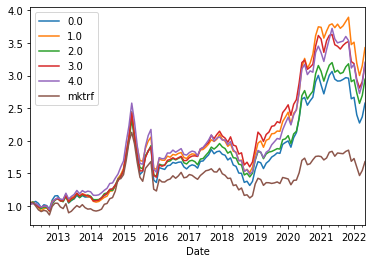

In [120]:
# 月度调仓
(RS_α[[0, 1, 2, 3, 4, 'mktrf']] + 1).cumprod().plot()

<AxesSubplot:xlabel='Date'>

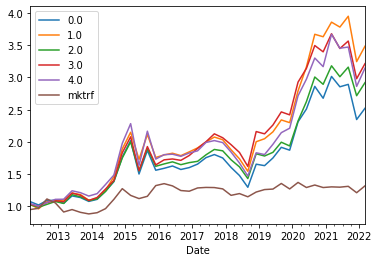

In [115]:
# 季度调仓
(RS_α[[0, 1, 2, 3, 4, 'mktrf']] + 1).cumprod().plot()

## VI. Performance Indicator

In [214]:
all_factors = [

all_fund_capm_α,
all_fund_svc_α,
all_fund_capm_α_ε,
all_fund_svc_α_ε,
- active_share,
ccp_capm_it,
ccp_svc_it,
rg_ret_t,

]

z_scored_all_factors = []

In [168]:
from scipy.stats import zscore

In [235]:
MIN_VALID_NUM = 15

for one_factor in all_factors:
    z_scored_all_factors.append(one_factor.apply(lambda x:\
         zscore(x.dropna()[np.logical_and(x.dropna() > x.dropna().quantile(.05), x.dropna() < x.dropna().quantile(.95))])\
         if pd.notna(x).sum() >= MIN_VALID_NUM else pd.Series([np.nan] * len(x), index=x.index), axis=1))


In [251]:
co_funds = np.intersect1d(pd.concat(z_scored_all_factors).groupby(level=0).mean().columns, filtered_funds.columns)
pd.concat(z_scored_all_factors).groupby(level=0).mean()[co_funds].apply(lambda x: x.nlargest(15).index, axis=1)

Date
2005-06    Index(['162102', '257010', '070001', '040001',...
2005-07    Index(['070001', '162203', '040001', '090001',...
2005-08    Index(['162102', '519011', '200002', '050002',...
2005-09    Index(['070002', '162201', '350001', '180001',...
2005-10    Index(['161605', '121002', '161601', '350001',...
                                 ...                        
2022-02    Index(['100022', '519678', '161025', '519005',...
2022-03    Index(['519678', '100022', '161025', '519005',...
2022-04    Index(['519678', '161025', '100022', '519005',...
2022-05    Index(['168002', '519678', '161025', '519005',...
2022-06    Index(['168002', '519678', '519005', '100022',...
Freq: M, Length: 205, dtype: object